In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [3]:
!wandb login 9676e3cc95066e4865586082971f2653245f09b4

wandb: Appending key for api.wandb.ai to your netrc file: /home/gd1279/.netrc
Successfully logged in to Weights & Biases!


In [4]:
import sys
sys.path.append('/home/gd1279/projects/Rainbow')

In [60]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from scipy.spatial import ConvexHull
from scipy.special import factorial
from sklearn.metrics import mean_squared_error

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import path as mpath
import matplotlib.gridspec as gridspec

import pickle
import tabulate
import wandb
from collections import defaultdict, deque, namedtuple
import os
import argparse
import atari_py
import torch
import torch.nn.functional as F
from operator import itemgetter

from agent import Agent
from env import make_env
from masker import ALL_MASKERS

In [6]:
np.set_printoptions(precision=5)

In [7]:
api = wandb.Api()

In [8]:
CHECKPOINT_SCRATCH_FOLDER = '/scratch/gd1279'

if not os.path.exists(CHECKPOINT_SCRATCH_FOLDER):
    os.mkdir(CHECKPOINT_SCRATCH_FOLDER)

# Recreate the args 

In [9]:
# Note that hyperparameters may originally be reported in ATARI game frames instead of agent steps
parser = argparse.ArgumentParser(description='Rainbow')
parser.add_argument('--id', type=str, default='default', help='Experiment ID')
parser.add_argument('--seed', type=int, default=123, help='Random seed')
parser.add_argument('--disable-cuda', action='store_true', help='Disable CUDA')
parser.add_argument('--game', type=str, default='space_invaders', choices=atari_py.list_games(), help='ATARI game')
parser.add_argument('--T-max', type=int, default=int(50e6), metavar='STEPS', help='Number of training steps (4x number of frames)')
parser.add_argument('--max-episode-length', type=int, default=int(108e3), metavar='LENGTH', help='Max episode length in game frames (0 to disable)')
parser.add_argument('--history-length', type=int, default=4, metavar='T', help='Number of consecutive states processed')
parser.add_argument('--architecture', type=str, default='canonical', choices=['canonical', 'data-efficient'], metavar='ARCH', help='Network architecture')
parser.add_argument('--hidden-size', type=int, default=512, metavar='SIZE', help='Network hidden size')
parser.add_argument('--noisy-std', type=float, default=0.1, metavar='σ', help='Initial standard deviation of noisy linear layers')
parser.add_argument('--atoms', type=int, default=51, metavar='C', help='Discretised size of value distribution')
parser.add_argument('--V-min', type=float, default=-10, metavar='V', help='Minimum of value distribution support')
parser.add_argument('--V-max', type=float, default=10, metavar='V', help='Maximum of value distribution support')
parser.add_argument('--model', type=str, metavar='PARAMS', help='Pretrained model (state dict)')
parser.add_argument('--memory-capacity', type=int, default=int(1e6), metavar='CAPACITY', help='Experience replay memory capacity')
parser.add_argument('--replay-frequency', type=int, default=4, metavar='k', help='Frequency of sampling from memory')
parser.add_argument('--priority-exponent', type=float, default=0.5, metavar='ω', help='Prioritised experience replay exponent (originally denoted α)')
parser.add_argument('--priority-weight', type=float, default=0.4, metavar='β', help='Initial prioritised experience replay importance sampling weight')
parser.add_argument('--multi-step', type=int, default=3, metavar='n', help='Number of steps for multi-step return')
parser.add_argument('--discount', type=float, default=0.99, metavar='γ', help='Discount factor')
parser.add_argument('--target-update', type=int, default=int(8e3), metavar='τ', help='Number of steps after which to update target network')
parser.add_argument('--reward-clip', type=int, default=1, metavar='VALUE', help='Reward clipping (0 to disable)')
parser.add_argument('--learning-rate', type=float, default=0.0000625, metavar='η', help='Learning rate')
parser.add_argument('--adam-eps', type=float, default=1.5e-4, metavar='ε', help='Adam epsilon')
parser.add_argument('--batch-size', type=int, default=32, metavar='SIZE', help='Batch size')
parser.add_argument('--learn-start', type=int, default=int(20e3), metavar='STEPS', help='Number of steps before starting training')
parser.add_argument('--evaluate', action='store_true', help='Evaluate only')
parser.add_argument('--evaluation-interval', type=int, default=100000, metavar='STEPS', help='Number of training steps between evaluations')
parser.add_argument('--evaluation-episodes', type=int, default=10, metavar='N', help='Number of evaluation episodes to average over')
parser.add_argument('--evaluation-size', type=int, default=500, metavar='N', help='Number of transitions to use for validating Q')
parser.add_argument('--render', action='store_true', help='Display screen (testing only)')
parser.add_argument('--enable-cudnn', action='store_true', help='Enable cuDNN (faster but nondeterministic)')
parser.add_argument('--save-evaluation-gifs', action='store_true', help='Save GIFs of evaluation episodes')
parser.add_argument('--evaluation-gif-folder', default=None, help='Folder to save evaluation GIFs in')
parser.add_argument('--save-evaluation-states', action='store_true', help='Save the states of evaluation episodes')
parser.add_argument('--evaluation-state-folder', default=None, help='Folder to save evaluation state in')

# Custom arguments I added

SCRATCH_FOLDER = r'/misc/vlgscratch4/LakeGroup/guy/'

DEFUALT_WANDB_ENTITY = 'augmented-frostbite'
parser.add_argument('--wandb-entity', default=DEFUALT_WANDB_ENTITY)
DEFAULT_WANDB_PROJECT = 'initial-experiments'
parser.add_argument('--wandb-project', default=DEFAULT_WANDB_PROJECT)
DEFAULT_WANDB_DIR = SCRATCH_FOLDER  # wandb creates its own folder inside
parser.add_argument('--wandb-dir', default=DEFAULT_WANDB_DIR)
parser.add_argument('--wandb-omit-watch', action='store_true')
parser.add_argument('--wandb-resume', action='store_true')
DEFAULT_MEMORY_SAVE_FOLDER = os.path.join(SCRATCH_FOLDER, 'rainbow_memory')
parser.add_argument('--memory-save-folder', default=DEFAULT_MEMORY_SAVE_FOLDER)
parser.add_argument('--memory-save-interval', type=int, default=None, help='How often to save the memory, defaults to the evaluation interval')
parser.add_argument('--use-native-pickle-serialization', action='store_true', help='Use native pickle saving rather than torch.save()')

# Arguments for the augmented representations
parser.add_argument('--add-masks', action='store_true', help='Add masks for each semantic object types')
parser.add_argument('--maskers', default=None, help='Select specific maskers to use')
parser.add_argument('--use-numpy-masker', action='store_true', help='Use the previous, much slower numpy-based masker')
parser.add_argument('--omit-pixels', action='store_true', help='Omit the raw pixels from the environment')

# Arguments to give it a soft time cap that will help it not fail
parser.add_argument('--soft-time-cap', help='Format: <DD>:HH:MM, stop after some soft cap such that the saving the memory does not fail')

# Debugging-related arguments
parser.add_argument('--debug-heap', action='store_true')
parser.add_argument('--heap-interval', default=1e4)
parser.add_argument('--heap-debug-file', default=None)


_StoreAction(option_strings=['--heap-debug-file'], dest='heap_debug_file', nargs=None, const=None, default=None, type=None, choices=None, help=None, metavar=None)

# Load a run and its model

In [10]:
def download_checkpoint(run, step=None):
    files = run.files()
    if step is None:
        step = max([int(f.name[f.name.rfind('-') + 1:f.name.rfind('.')]) 
                    for f in files 
                    if f.name.endswith('.pth')])
        
    sample_name = [f.name for f in files if f.name.endswith('.pth')][0]
    checkpoint_name = sample_name[:sample_name.rfind('-')]
    checkpoint_file = f'{checkpoint_name}-{step}.pth'
    run.file(checkpoint_file).download(replace=True, root=CHECKPOINT_SCRATCH_FOLDER)
    return os.path.join(CHECKPOINT_SCRATCH_FOLDER, checkpoint_file)


def setup_args(run):
    args = parser.parse_args([])
    config = run.config
    
    for key in config:
        if key in args:
            args.__setattr__(key, config[key])
            
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)

    if torch.cuda.is_available() and not args.disable_cuda:
        args.device = torch.device('cuda')
        # torch.cuda.manual_seed(np.random.randint(1, 10000))
        torch.cuda.manual_seed(args.seed)
        torch.backends.cudnn.enabled = args.enable_cudnn
    else:
        args.device = torch.device('cpu')
            
    return args


LOADED_MODEL_CACHE = {}


def load_model_from_run(run, step=None, cache=LOADED_MODEL_CACHE):
    key = (run, step)
    if key not in cache:
        checkpoint_path = download_checkpoint(run, step)
        args = setup_args(run)
        args.model = checkpoint_path

        env = make_env(args)
        dqn = Agent(args, env)
        cache[key] = dqn, env
        
    return cache[key]

# Gameplan

1. Load the saved full-res/color states.
2. Pass them through the baseline model and create/plot t-SNE embeddings.
3. Color them by their value (according to the baseline model)

This essentially recreates the analysis in the Nature DQN paper.

4. Augment the states and pass them through an augmented model.
5. Color by the value differences between models. If the distribution is vastly different, consider normalizing.
6. Repeat this exercise for baseline and masks+pixels, baseline and masks, and masks+pixels and masks.
7. Show sample states/images from different clusters

Questions:

* Do I want to use every single state? Or maybe skip and use every other or something?

## Utilities

In [75]:
FIGURE_TEMPLATE = r'''\begin{{figure}}[!htb]
% \vspace{{-0.225in}}
\centering
\includegraphics[width=\linewidth]{{figures/{save_path}}}
\caption{{ {{\bf FIGURE TITLE.}} FIGURE DESCRIPTION.}}
\label{{fig:{label_name}}}
% \vspace{{-0.2in}}
\end{{figure}}
'''
WRAPFIGURE_TEMPLATE = r'''\begin{{wrapfigure}}{{r}}{{0.5\linewidth}}
\vspace{{-.3in}}
\begin{{spacing}}{{1.0}}
\centering
\includegraphics[width=0.95\linewidth]{{figures/{save_path}}}
\caption{{ {{\bf FIGURE TITLE.}} FIGURE DESCRIPTION.}}
\label{{fig:{label_name}}}
\end{{spacing}}
% \vspace{{-.25in}}
\end{{wrapfigure}}'''

SAVE_PATH_PREFIX = 'figures'


def save(save_path, bbox_inches='tight'):
    if save_path is not None:
        save_path_no_ext = os.path.splitext(save_path)[0]
        print('Figure:\n')
        print(FIGURE_TEMPLATE.format(save_path=save_path, label_name=save_path_no_ext.replace('/', '-').replace('_', '-')))
        print('\n Wrapfigure:\n')
        print(WRAPFIGURE_TEMPLATE.format(save_path=save_path, label_name=save_path_no_ext.replace('/', '-').replace('_', '-')))
        print('')
        
        if not save_path.startswith(SAVE_PATH_PREFIX):
            save_path = os.path.join(SAVE_PATH_PREFIX, save_path)
        
        folder, filename = os.path.split(save_path)
        os.makedirs(folder, exist_ok=True)
        plt.savefig(save_path, bbox_inches=bbox_inches, facecolor=plt.gcf().get_facecolor(), edgecolor='none')


In [145]:
from MulticoreTSNE import MulticoreTSNE as TSNE


ModelResults = namedtuple('ModelResults', 
                          ('hidden_states', 'q_values', 'state_values', 'actions'))

KeyIndex = namedtuple('KeyIndex',
                      ('peak_index', 'peak_value', 'start', 'end', 'count', 'indices'))


def rgb_to_grayscale(obs):
    # My best approximation of how the ALE does it
    rgb = obs.astype('float32')
    return (rgb[:,:,0] * 0.299 + rgb[:,:,1] * 0.587 + rgb[:,:,2] * 0.114).astype(np.uint8)


def observation_to_model(env, obs):
    return env._prepare_state(env._to_tensor(rgb_to_grayscale(obs)), env._to_tensor(obs))


MAX_STATE_IDX = None
SKIP = 2


def pass_states_through_model(model, env, observations, max_state_idx=MAX_STATE_IDX, skip=SKIP):
    state_buffer = deque([], maxlen=4)
    hidden_states = []
    q_values = []
    state_values = []
    actions = []

    for frame in observations[:3]:
        state_buffer.append(observation_to_model(env, frame))

    with torch.no_grad():
        for frame in observations[3:max_state_idx]:
            state_buffer.append(observation_to_model(env, frame))
            state = torch.cat(list(state_buffer), 0)
            
            hidden_state = model.online_net.convs(state.unsqueeze(0)).view(-1)
            hidden_states.append(hidden_state.detach().cpu().numpy())
            
            q_values.append(model.expected_q_values(state))
            state_values.append(model.evaluate_q(state))
            actions.append(model.act(state))

    hidden_state_array = np.array(hidden_states[::skip])
    q_values_array = np.array(q_values[::skip])
    state_value_array = np.array(state_values[::skip])
    action_array = np.array(actions[::skip])
    
    return ModelResults(hidden_state_array, q_values_array, state_value_array, action_array)


def plot_entire_state(observations, start_index, num_frames=4):
    figure = plt.figure(figsize=(18, 4))
    for i in range(num_frames):
        ax = plt.subplot(1, num_frames, i + 1)
        ax.imshow(observations[start_index + i])
        
    plt.show()
    

def plot_embeddings_and_state(embeddings, color_values, observations, start_index, special_indices=None, num_frames=4,
                              low_alpha=0.1, medium_alpha=0.7, alpha_threshold=0.7):
    fig = plt.figure(constrained_layout=True, figsize=(16, 8))
    gs = fig.add_gridspec(2, 4)
    
    tsne_ax = fig.add_subplot(gs[:, :2])
    cmap = matplotlib.cm.get_cmap('Spectral_r')
    normalizer = matplotlib.colors.Normalize(np.min(color_values), np.max(color_values))

    colors = np.array([cmap(normalizer(d)) for d in color_values])
    colors[:,3] = np.abs(color_values) / np.max(np.abs(color_values))
    colors[colors[:,3] > alpha_threshold, 3] = medium_alpha
    colors[colors[:,3] < alpha_threshold, 3] = low_alpha

    mask = np.zeros(Y.shape[0], dtype=bool)
    if special_indices is not None:
        mask[special_indices] = True
        colors[mask, 3] = 1

    tsne_ax.scatter(embeddings[~mask, 0], embeddings[~mask, 1], color=colors[~mask])
    tsne_ax.scatter(embeddings[mask, 0], embeddings[mask, 1], color='purple', s=50, marker='x')
    plt.colorbar(matplotlib.cm.ScalarMappable(norm=normalizer, cmap=cmap), ax=tsne_ax)
    
    for i in range(num_frames):
        ax = fig.add_subplot(gs[i // 2, 2 + (i % 2)])
        ax.imshow(observations[start_index + i])
        ax.xaxis.set_major_locator(plt.NullLocator())
        ax.yaxis.set_major_locator(plt.NullLocator())
        
    plt.show()
    
    
def plot_observations(observations, start, count, step):
    plt.figure(figsize=(3 * count, 4))
    for i, idx in enumerate(range(start, start + count * step, step)):
        ax = plt.subplot(1, count, i + 1)
        ax.imshow(observations[idx])
        ax.xaxis.set_major_locator(plt.NullLocator())
        ax.yaxis.set_major_locator(plt.NullLocator())
        ax.set_title(idx)
        
    plt.show()
    
def plot_observations_by_indices(observations, indices, title=True, wspace=0.1, hspace=None, shape=None):
    n = len(indices)
    
    if shape is None:
        shape = (1, n)
    
    plt.figure(figsize=(3 * shape[1], 4 * shape[0]))
    
    if hspace is None:
        hspace = wspace
    
    plt.subplots_adjust(hspace=hspace, wspace=wspace)
    
    for i, idx in enumerate(indices):
        ax = plt.subplot(*shape, i + 1)
        ax.imshow(observations[idx])
        ax.xaxis.set_major_locator(plt.NullLocator())
        ax.yaxis.set_major_locator(plt.NullLocator())
        if title: ax.set_title(idx)
        
    plt.show()
    
    
    
ALE_ACTIONS = {
    0: 'noop',
    1: 'fire',
    2: 'up',
    3: 'right',
    4: 'left',
    5: 'down',
    6: 'up + right',
    7: 'up + left',
    8: 'down + right',
    9: 'down + left',
    10: 'up + fire',
    11: 'right + fire',
    12: 'left + fire',
    13: 'down + fire',
    14: 'up + right + fire',
    15: 'up + left + fire',
    16: 'down + right + fire',
    17: 'down + left + fire'
}


def print_model_state_description(results, name, index, top_k=3):
    value = results.state_values[index]
    action = results.actions[index]
    print(f'{name} had value {value:.3f} => {ALE_ACTIONS[action]} ({action})')
    q = results.q_values[index].cpu().numpy()
    top_actions = np.argpartition(q, -top_k)[-top_k:]
    top_actions = top_actions[np.argsort(q[top_actions])][::-1]
    p = F.softmax(results.q_values[index], dim=0)
    print(' | '.join([f'({i + 1}) {ALE_ACTIONS[a]} [{a}], Q = {q[a]:.3f}, P = {p[a]:.3f}' for i, a in enumerate(top_actions)]))

    
def describe_states_by_indices(indices, first_model_results, first_model_name, second_model_results, second_model_name, 
                               observations, embeddings, color_values, top_k=3, plot_embeddings=False):
    for key_index in sorted(indices, key=lambda ki: ki.peak_index):
        index = key_index.peak_index
        print(f'At index {index}')
        print_model_state_description(first_model_results, first_model_name, index, top_k)
        print_model_state_description(second_model_results, second_model_name, index, top_k)
        
        if plot_embeddings:
            plot_embeddings_and_state(embeddings, color_values, observations, 
                                      key_index.peak_index, 
                                      special_indices=key_index.indices)
        else:
            plot_entire_state(observations, index)
    
    
def find_diverging_states(values, indices, min_distance=10):
    index_values = [values[i] for i in indices]
    output = [KeyIndex(indices[0], index_values[0], indices[0], indices[0], 1, [indices[0]])]
    
    for index, value in zip(indices[1:], index_values[1:]):
        current = output[-1]
        
        # Sufficiently far away, append a new one
        if index > current.end + min_distance:
            output.append(KeyIndex(index, value, index, index, 1, [index]))
            
        # Value more extreme, replace peak
        elif abs(value) > abs(current.peak_value):  
            output[-1] = KeyIndex(index, value, current.start, index, current.count + 1, current.indices + [index])
            
        # Value not more extreme, extend
        else:
            output[-1] = KeyIndex(current.peak_index, current.peak_value, current.start, index, current.count + 1, current.indices + [index])
            
    return output

In [12]:
def load_all_models(*run_urls, run_checker=lambda t: True, step=None):
    runs = [run for run in api.runs(run_urls[0]) if run_checker(run)]
    for url in run_urls[1:]:
        runs.extend([run for run in api.runs(url) if run_checker(run)])
    
    loaded_models_and_envs = [load_model_from_run(run, step) for run in runs]
    return zip(*loaded_models_and_envs)


all_baseline_models, all_baseline_envs = load_all_models('augmented-frostbite/initial-experiments/runs', 
                                                         run_checker=lambda run: run.name.lower().startswith('baseline-rainbow-3'),
                                                         step=10000000)

all_masks_and_pixels_models, all_masks_and_pixels_envs = load_all_models(#'augmented-frostbite/masks-and-pixels-fixed-resume/runs',
                                                                         'augmented-frostbite/masks-and-pixels-replication/runs',
                                                                         step=10000000)

all_masks_only_models, all_masks_only_envs = load_all_models(#'augmented-frostbite/masks-only/runs',
                                                             'augmented-frostbite/masks-only-replication/runs',
                                                             step=10000000)

print(len(all_baseline_models), len(all_masks_and_pixels_models), len(all_masks_only_models))

Loading pretrained model: /scratch/gd1279/baseline-rainbow-300-10000000.pth
Loading pretrained model: /scratch/gd1279/baseline-rainbow-309-10000000.pth
Loading pretrained model: /scratch/gd1279/baseline-rainbow-306-10000000.pth
Loading pretrained model: /scratch/gd1279/baseline-rainbow-308-10000000.pth
Loading pretrained model: /scratch/gd1279/baseline-rainbow-304-10000000.pth
Loading pretrained model: /scratch/gd1279/baseline-rainbow-305-10000000.pth
Loading pretrained model: /scratch/gd1279/baseline-rainbow-307-10000000.pth
Loading pretrained model: /scratch/gd1279/baseline-rainbow-303-10000000.pth
Loading pretrained model: /scratch/gd1279/baseline-rainbow-301-10000000.pth
Loading pretrained model: /scratch/gd1279/baseline-rainbow-302-10000000.pth
Loading pretrained model: /scratch/gd1279/masks-and-pixels-replication-309-10000000.pth
Loading pretrained model: /scratch/gd1279/masks-and-pixels-replication-308-10000000.pth
Loading pretrained model: /scratch/gd1279/masks-and-pixels-repli

## 1

In [13]:
SAMPLE_SAVED_STATES = r'/home/gd1279/scratch/rainbow-evaluation-state-traces/baseline-rainbow-305/evaluation/states/eval-baseline-rainbow-305-34350000-0-env.pickle'

with open(SAMPLE_SAVED_STATES, 'rb') as state_file:
    sample_full_color_observations = pickle.load(state_file)
    
    
sample_full_color_observations = sample_full_color_observations.astype(np.uint8)
print(sample_full_color_observations.shape)

(5671, 210, 160, 3)


## 2

Using model 306 from the baseline condition, one of the average models, not the 'superstar' one

In [14]:
baseline_run = api.run('augmented-frostbite/initial-experiments/runs/fdxobftk')
baseline_model, baseline_env = load_model_from_run(baseline_run, 10000000)

Loading pretrained model: /scratch/gd1279/baseline-rainbow-306-10000000.pth


In [17]:
baseline_model_results = pass_states_through_model(baseline_model, baseline_env, sample_full_color_observations, skip=1)

baseline_model_results.hidden_states.shape

(5668, 3136)

In [18]:
tsne = TSNE(n_jobs=4)
Y = tsne.fit_transform(baseline_model_results.hidden_states)
Y.shape

(5668, 2)

## 3

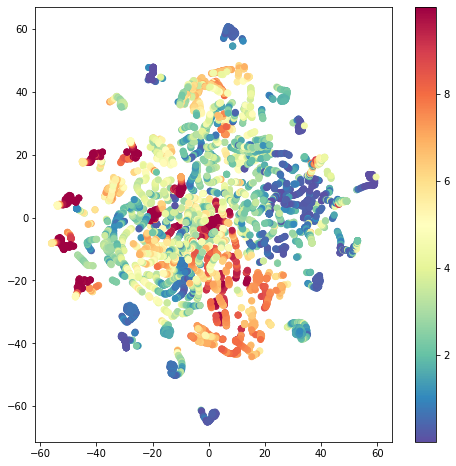

In [19]:
plt.figure(figsize=(8, 8))
cmap = matplotlib.cm.get_cmap('Spectral_r')
plt.scatter(Y[:, 0], Y[:, 1], c=baseline_model_results.state_values, cmap=cmap)
plt.colorbar()

(array([1123.,  577.,  651.,  668.,  527.,  366.,  542.,  442.,  228.,
         544.]),
 array([2.85729e-03, 1.00257e+00, 2.00229e+00, 3.00200e+00, 4.00171e+00,
        5.00143e+00, 6.00114e+00, 7.00085e+00, 8.00057e+00, 9.00028e+00,
        1.00000e+01]),
 <a list of 10 Patch objects>)

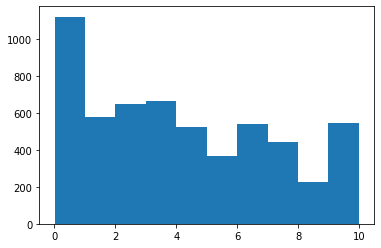

In [20]:
plt.hist(baseline_model_results.state_values)

# Addendum -- what if we do this averaged across all models

In [24]:
all_baseline_results = [pass_states_through_model(model, env, sample_full_color_observations, skip=1)
                        for (model, env) in zip(all_baseline_models, all_baseline_envs)]

all_masks_and_pixels_results = [pass_states_through_model(model, env, sample_full_color_observations, skip=1)
                        for (model, env) in zip(all_masks_and_pixels_models, all_masks_and_pixels_envs)]

all_masks_only_results = [pass_states_through_model(model, env, sample_full_color_observations, skip=1)
                        for (model, env) in zip(all_masks_only_models, all_masks_only_envs)]

/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


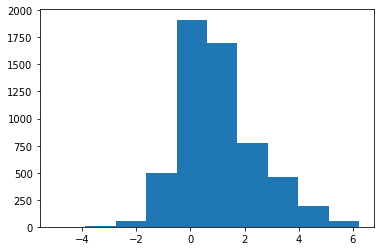

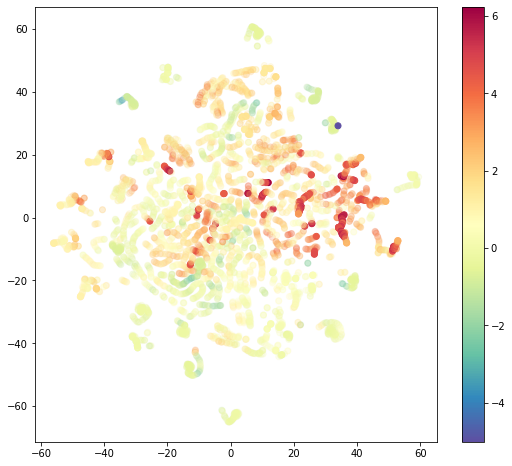

In [38]:
mean_baseline_state_values = np.stack([results.state_values for results in all_baseline_results]).mean(0)
mean_masks_and_pixels_state_values = np.stack([results.state_values for results in all_masks_and_pixels_results]).mean(0)

mean_diffs = mean_masks_and_pixels_state_values - mean_baseline_state_values

plt.hist(mean_diffs)
plt.show()

plt.figure(figsize=(9, 8))
cmap = matplotlib.cm.get_cmap('Spectral_r')
normalizer = matplotlib.colors.Normalize(np.min(mean_diffs), np.max(mean_diffs))

colors = np.array([cmap(normalizer(d)) for d in mean_diffs])
colors[:,3] = np.abs(mean_diffs) / np.max(np.abs(mean_diffs))
colors[colors[:,3] > 0.7, 3] = 1
colors[colors[:,3] < 0.7, 3] = 0.2

plt.scatter(Y[:, 0], Y[:, 1], color=colors)
plt.colorbar(matplotlib.cm.ScalarMappable(norm=normalizer, cmap=cmap), ax=plt.gca())
plt.show()

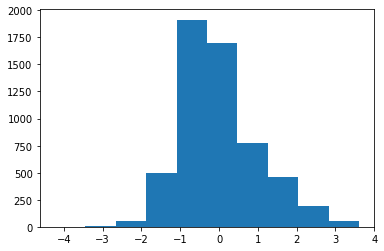

Figure:

\begin{figure}[!htb]
% \vspace{-0.225in}
\centering
\includegraphics[width=\linewidth]{figures/t_sne_base.pdf}
\caption{ {\bf FIGURE TITLE.} FIGURE DESCRIPTION.}
\label{fig:t-sne-base}
% \vspace{-0.2in}
\end{figure}


 Wrapfigure:

\begin{wrapfigure}{r}{0.5\linewidth}
\vspace{-.3in}
\begin{spacing}{1.0}
\centering
\includegraphics[width=0.95\linewidth]{figures/t_sne_base.pdf}
\caption{ {\bf FIGURE TITLE.} FIGURE DESCRIPTION.}
\label{fig:t-sne-base}
\end{spacing}
% \vspace{-.25in}
\end{wrapfigure}



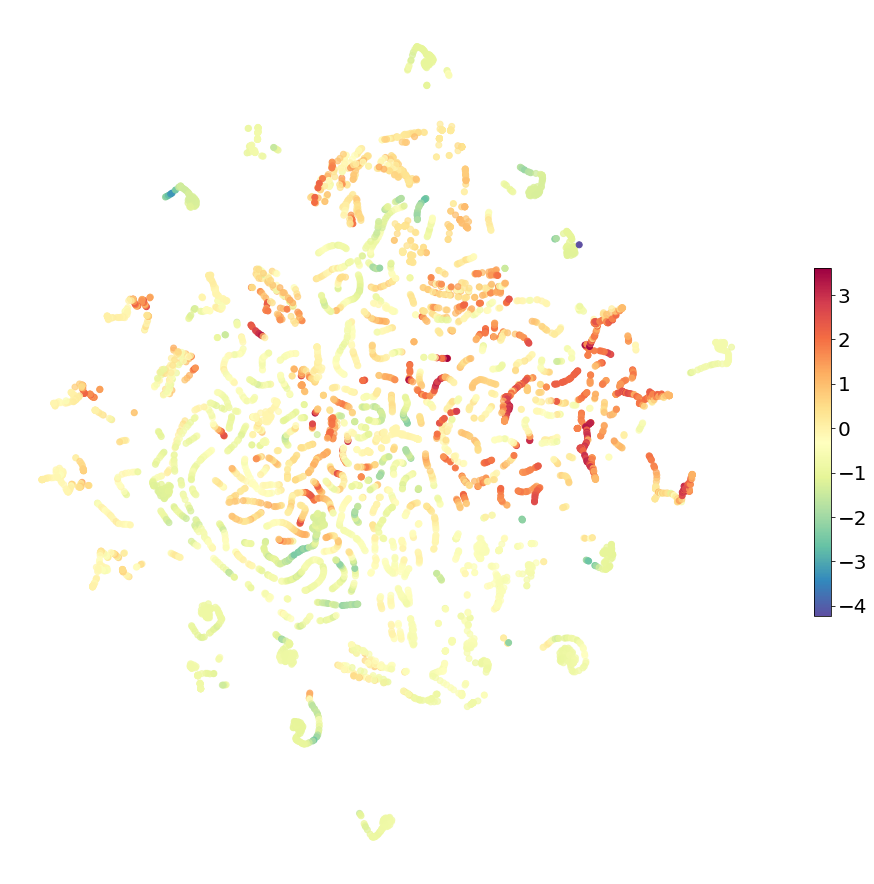

In [152]:
normalized_mean_diffs = (mean_diffs - mean_diffs.mean()) / mean_diffs.std()

plt.hist(normalized_mean_diffs)
plt.show()

plt.figure(figsize=(17, 16), frameon=False)
cmap = matplotlib.cm.get_cmap('Spectral_r')
normalizer = matplotlib.colors.Normalize(np.min(normalized_mean_diffs), np.max(normalized_mean_diffs))

colors = np.array([cmap(normalizer(d)) for d in normalized_mean_diffs])
# colors[:,3] = np.abs(normalized_mean_diffs) / np.max(np.abs(normalized_mean_diffs))
colors[:,3] = 0.75
colors[normalized_mean_diffs > MIN_VALUE_DIFF, 3] = 1
colors[normalized_mean_diffs < -MIN_VALUE_DIFF, 3] = 1
# colors[colors[:,3] < 0.7, 3] = 0.5

plt.scatter(Y[:, 0], Y[:, 1], color=colors)
cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=normalizer, cmap=cmap), ax=plt.gca(), shrink=0.4)
cbar.ax.tick_params(labelsize=20) 
# plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().axis('off')
# plt.gca().yaxis.set_major_locator(plt.NullLocator())

save('t_sne_base.pdf')

plt.show()

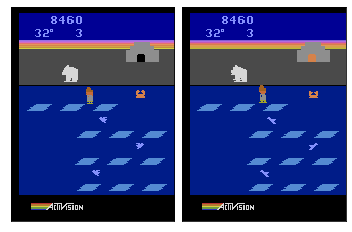

In [109]:
v

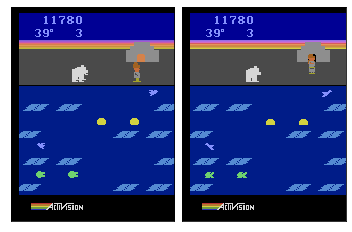

In [116]:
plot_observations_by_indices(sample_full_color_observations, filtered_mean_m_p_higher_indices[2].indices[19:21], title=False, wspace=0.05)

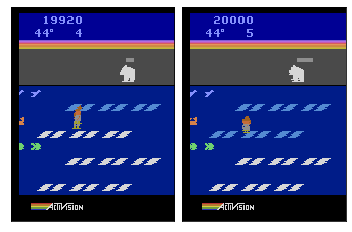

In [128]:
plot_observations_by_indices(sample_full_color_observations, filtered_mean_m_p_higher_indices[5].indices[2:4], title=False, wspace=0.05)

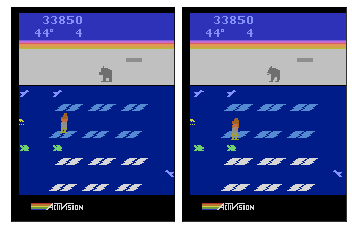

In [130]:
plot_observations_by_indices(sample_full_color_observations, filtered_mean_m_p_higher_indices[8].indices[2:4], title=False, wspace=0.05)

28 17
(0) At index 1662, the count is 69


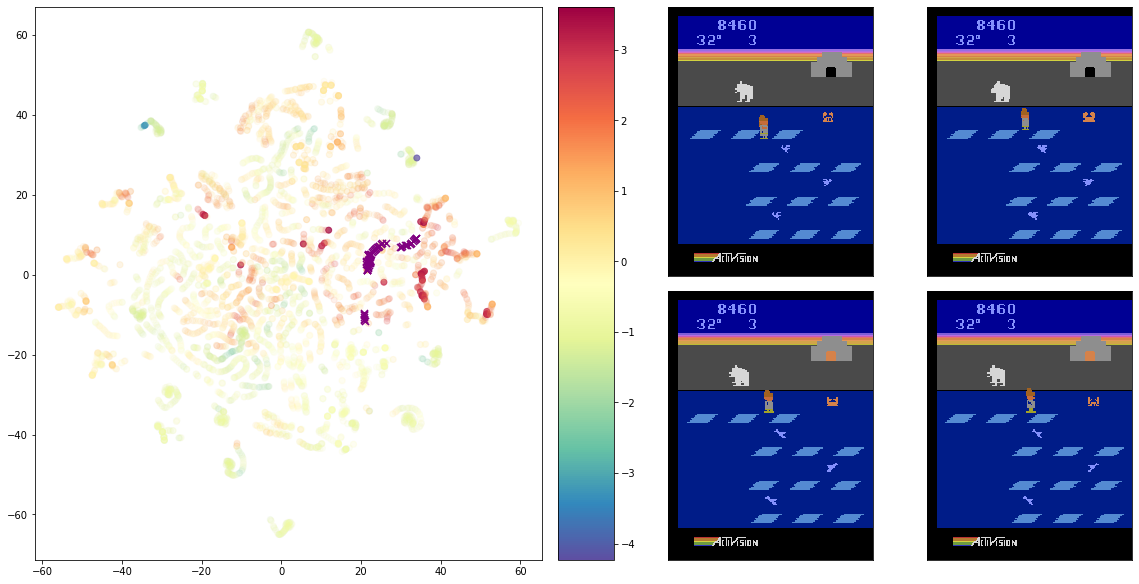

(1) At index 1912, the count is 17


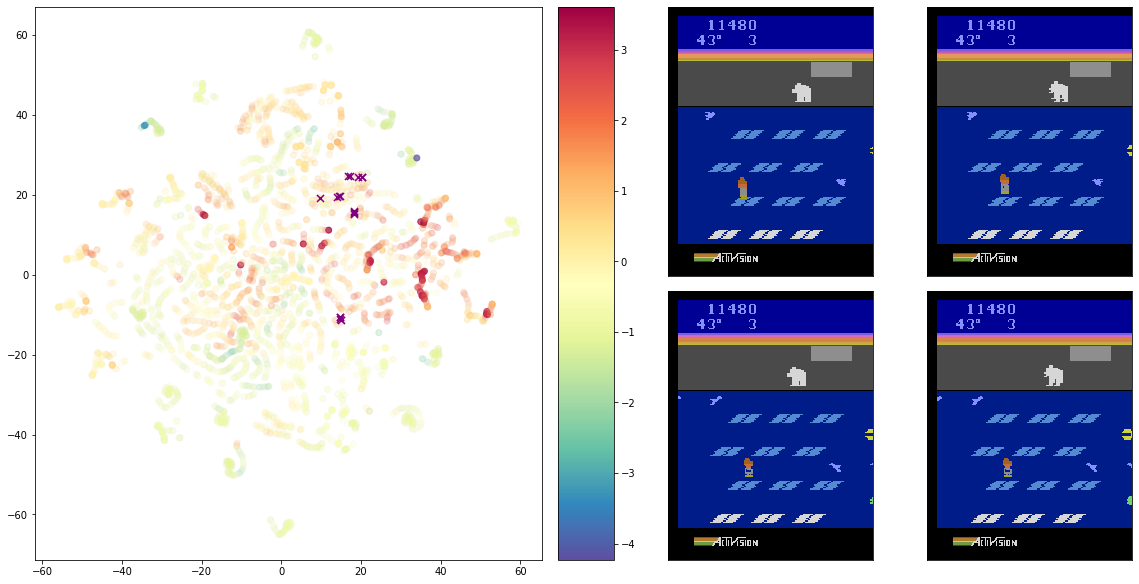

(2) At index 1981, the count is 72


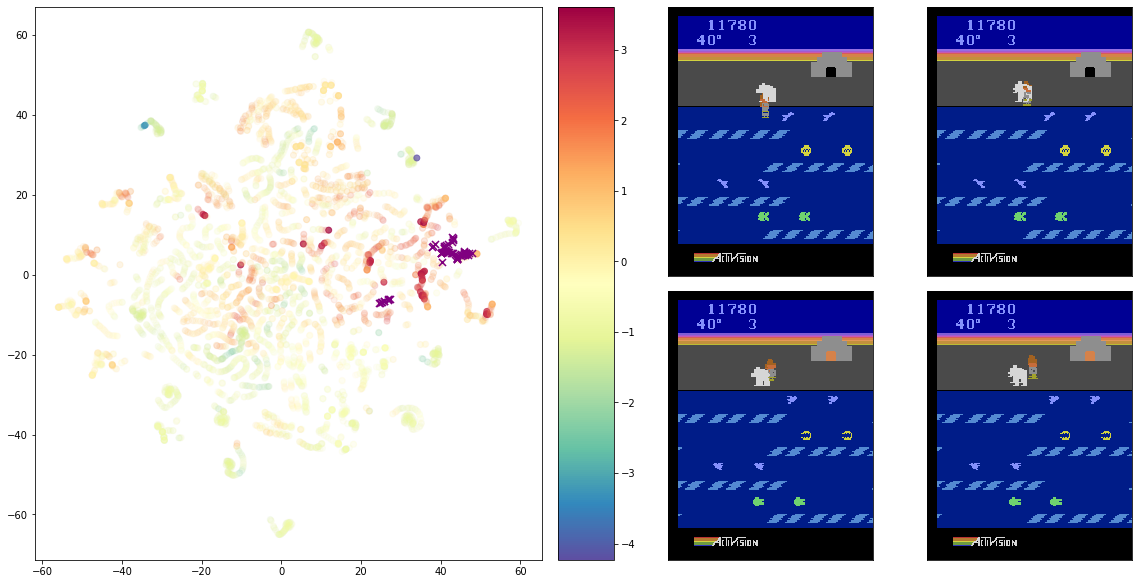

(3) At index 2234, the count is 13


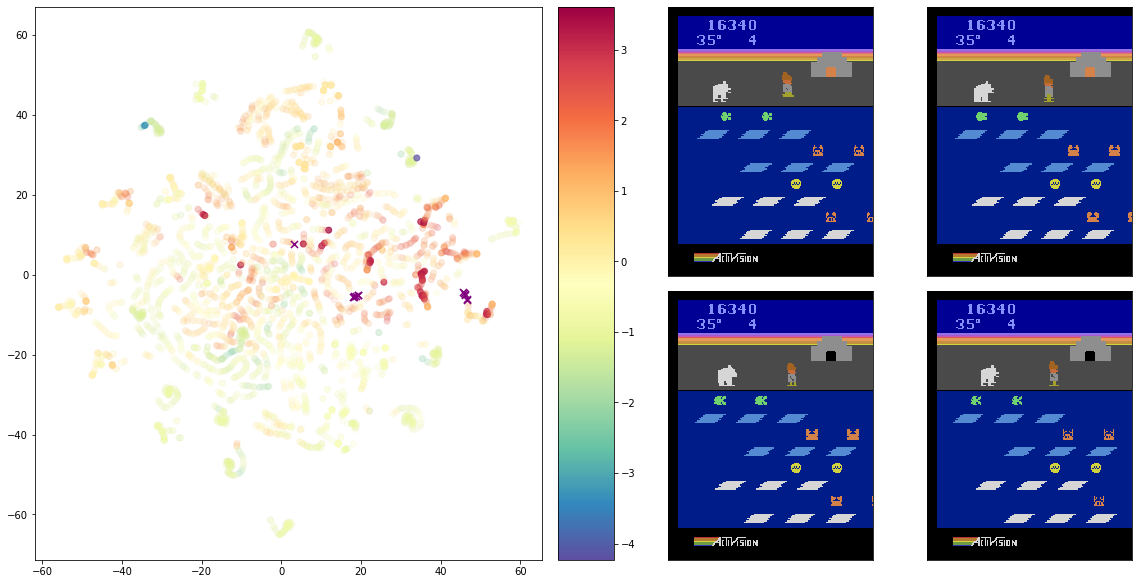

(4) At index 2295, the count is 23


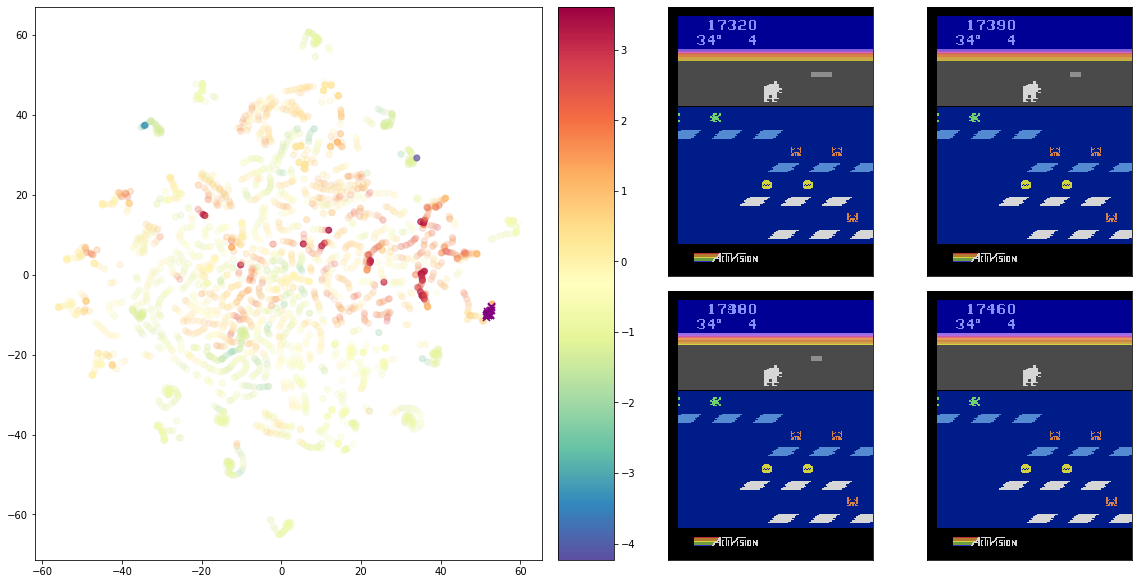

(5) At index 2388, the count is 32


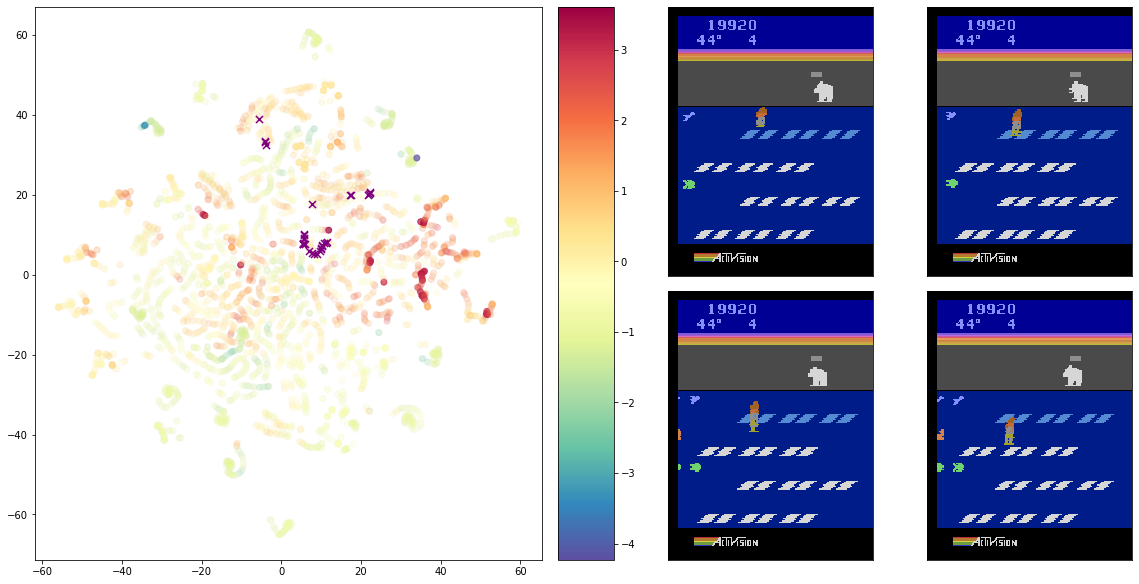

(6) At index 2662, the count is 78


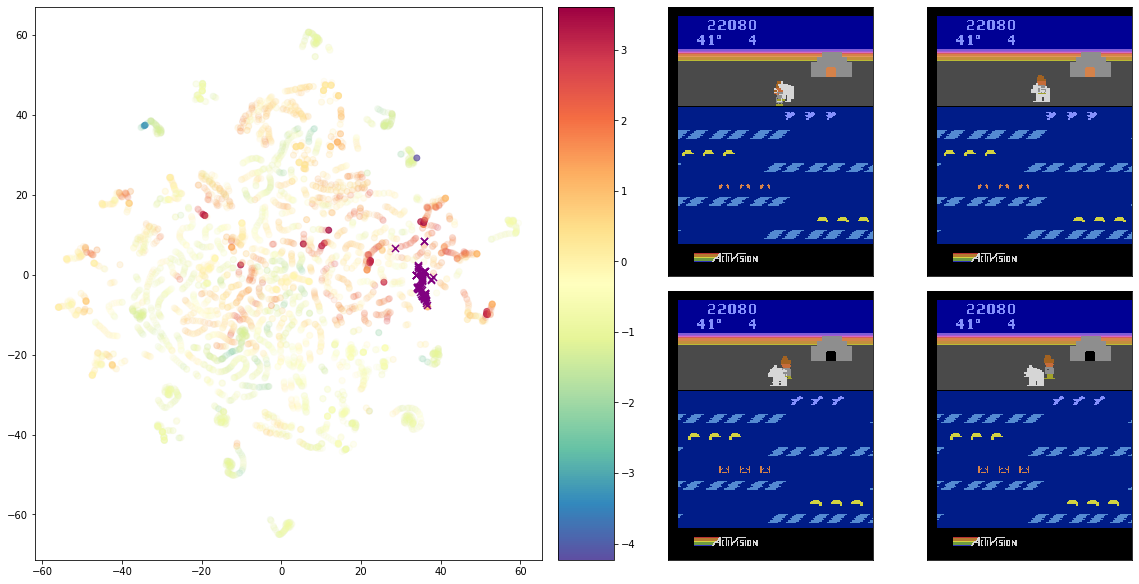

(7) At index 2782, the count is 16


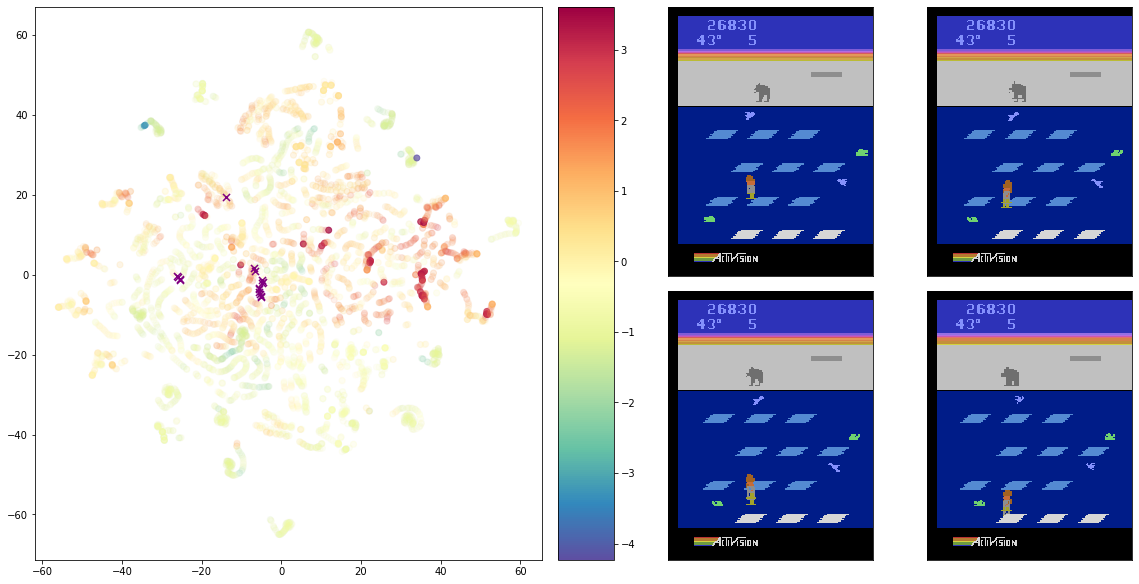

(8) At index 3303, the count is 17


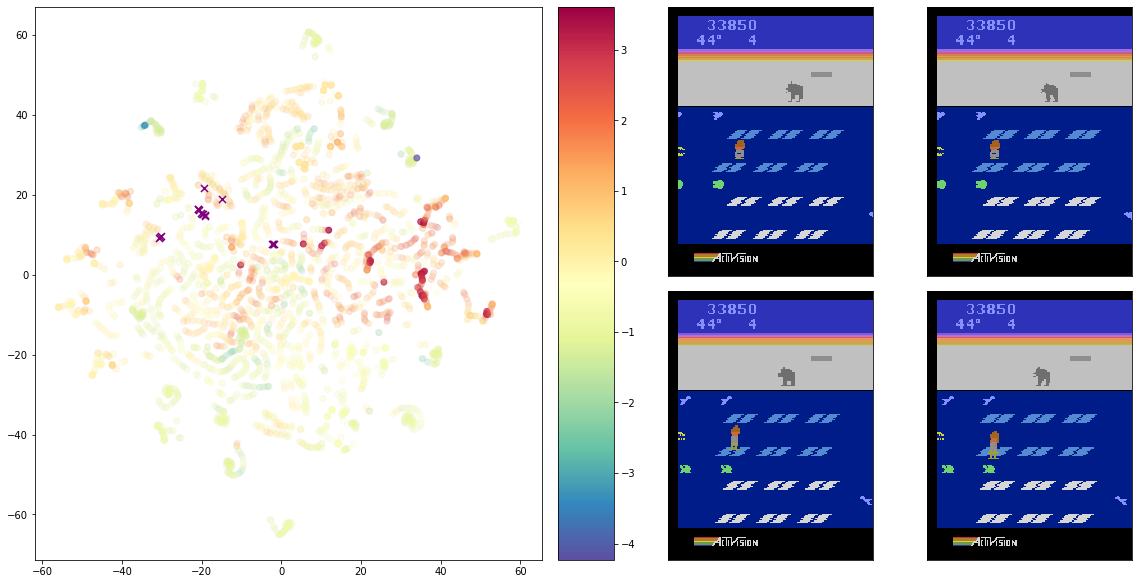

(9) At index 3702, the count is 13


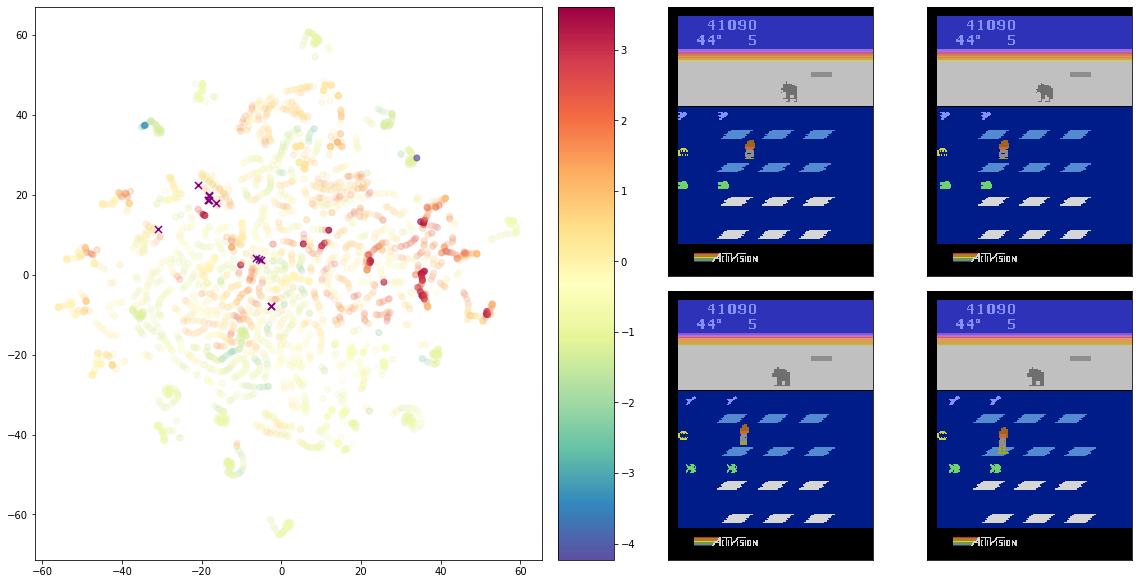

(10) At index 3985, the count is 12


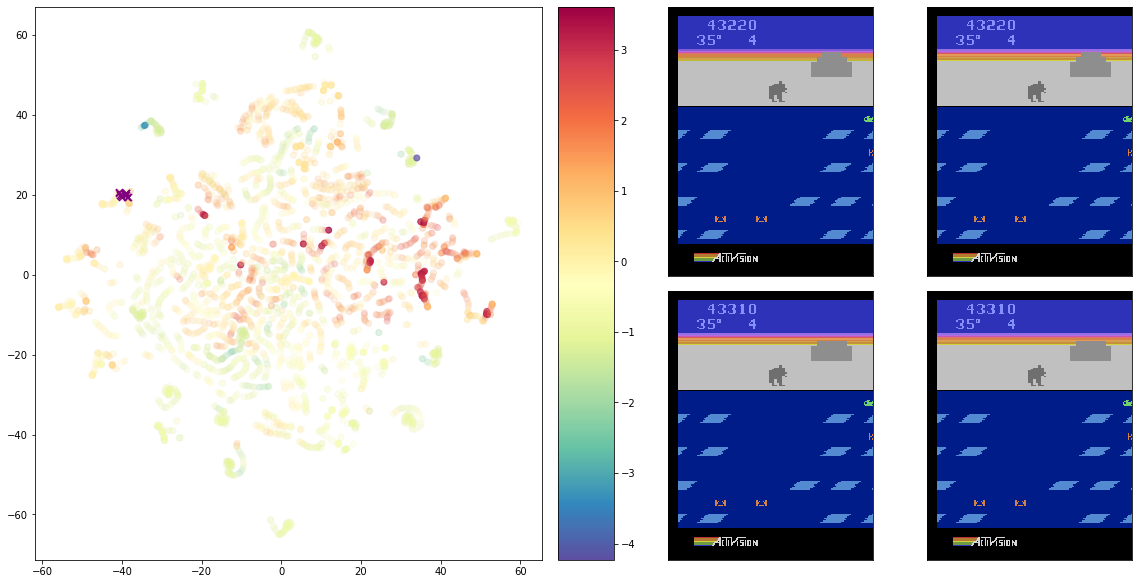

(11) At index 4529, the count is 10


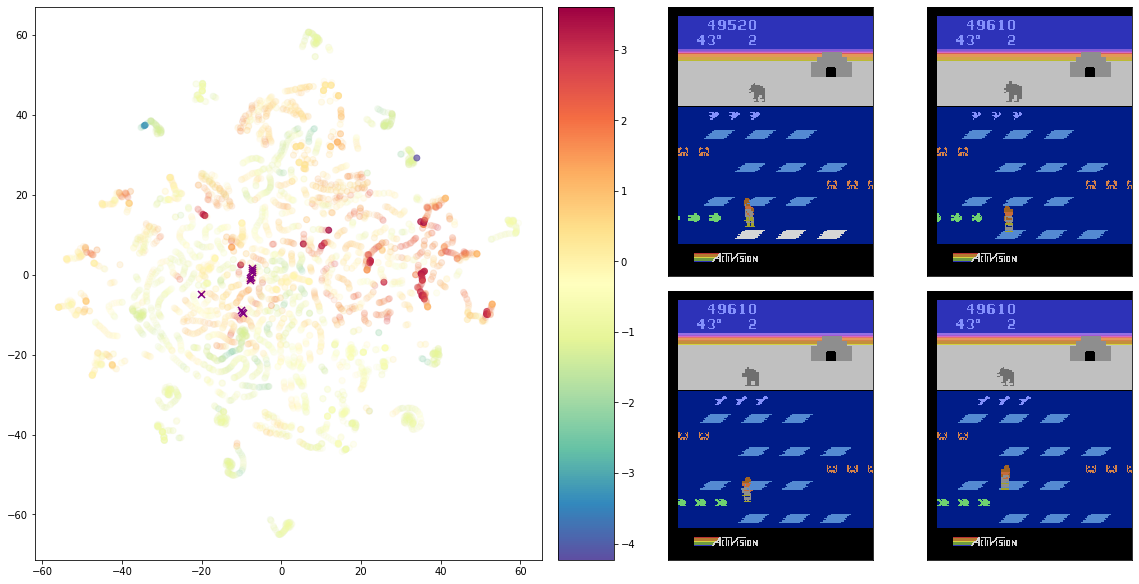

(12) At index 4593, the count is 13


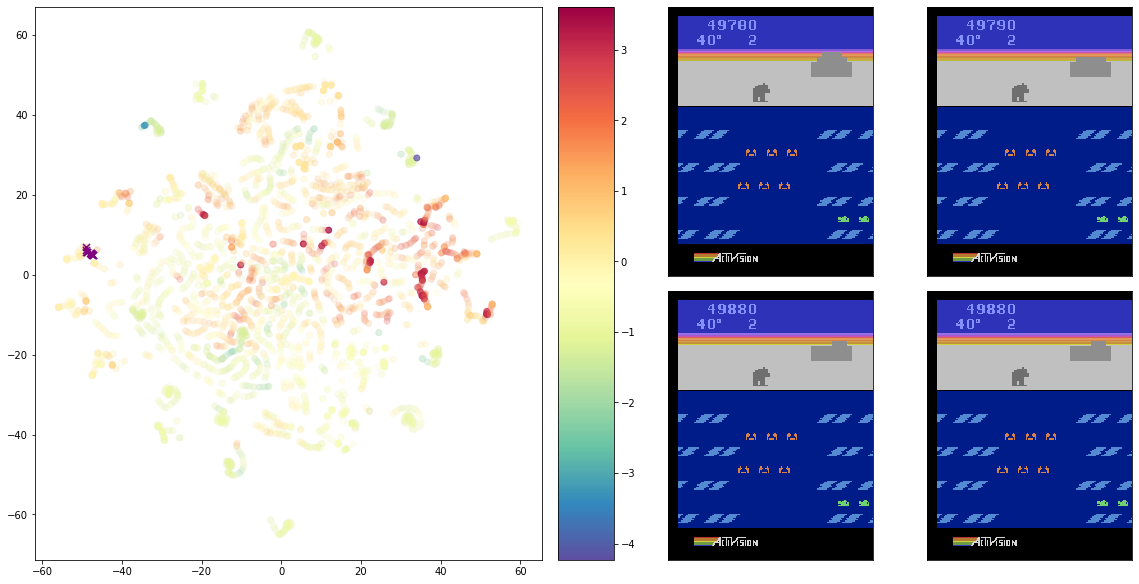

(13) At index 4930, the count is 11


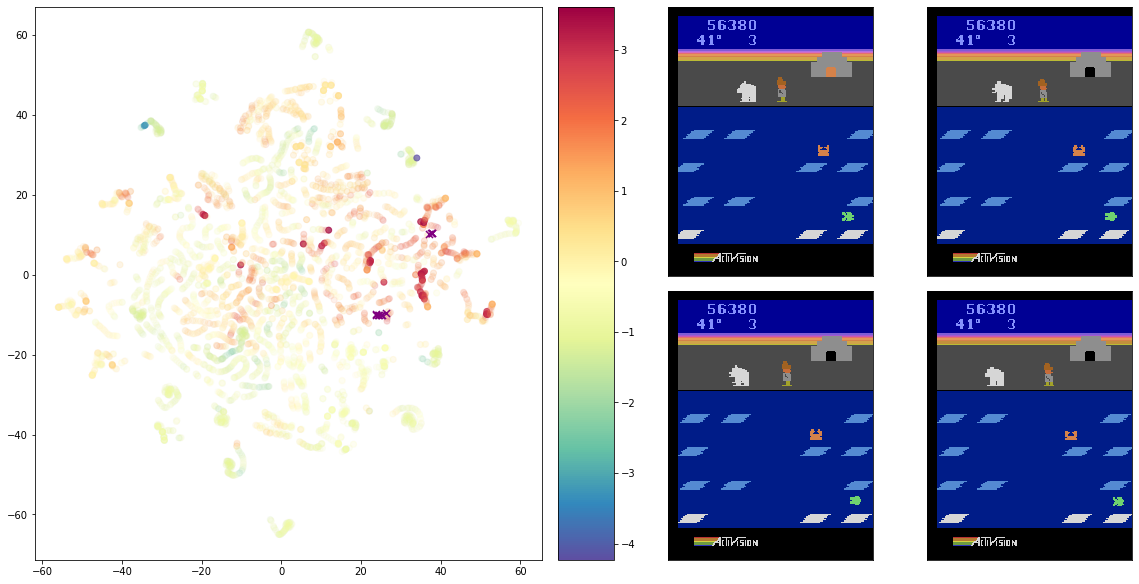

(14) At index 5110, the count is 75


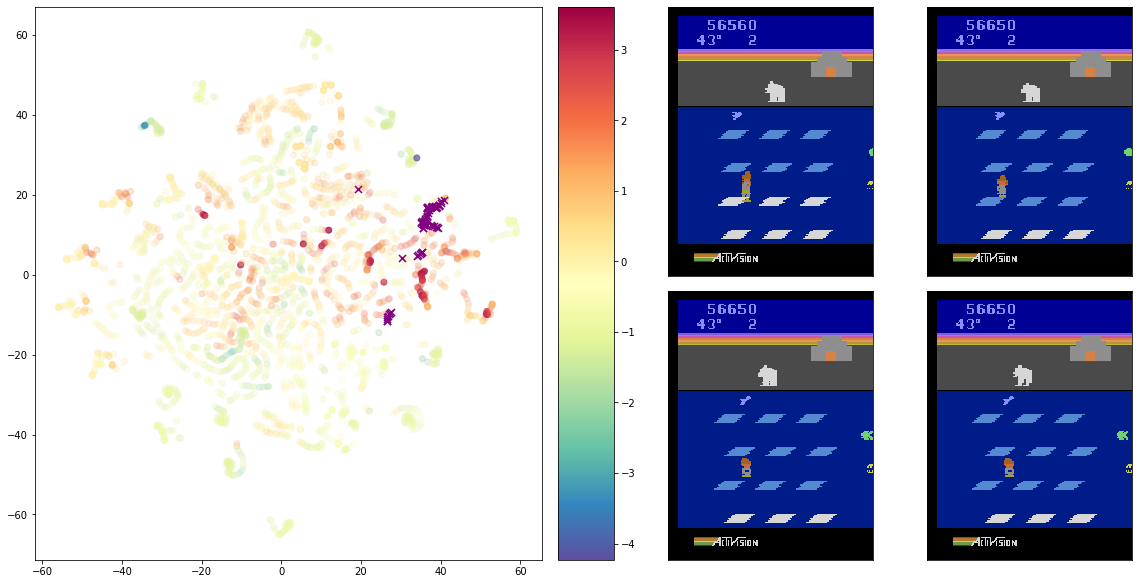

(15) At index 5238, the count is 20


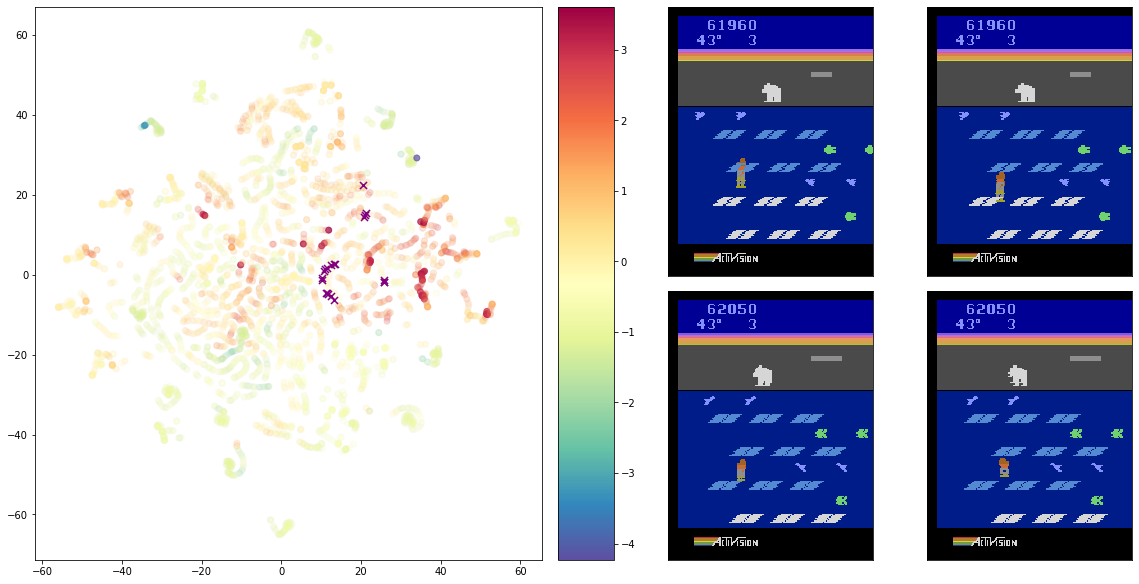

(16) At index 5652, the count is 21


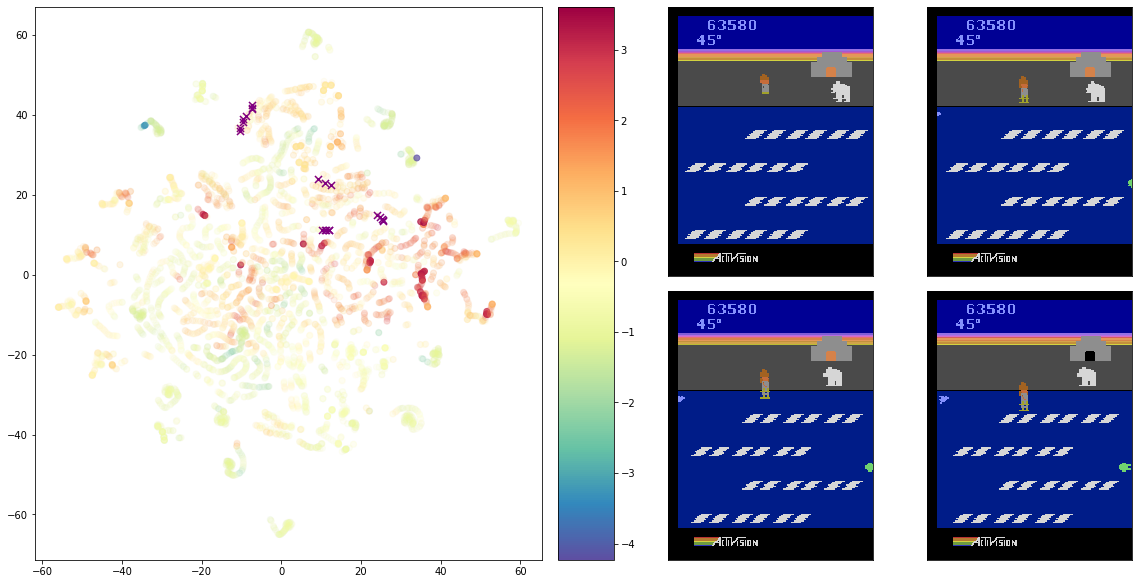

In [118]:
MIN_COUNT = 10
MIN_DISTANCE = 20
MIN_VALUE_DIFF = 1.5

mean_m_p_higher_indices = find_diverging_states(normalized_mean_diffs, np.nonzero(normalized_mean_diffs > MIN_VALUE_DIFF)[0], min_distance=MIN_DISTANCE)

filtered_mean_m_p_higher_indices = list(filter(lambda ki: ki.count >= MIN_COUNT, mean_m_p_higher_indices))
print(len(mean_m_p_higher_indices), len(filtered_mean_m_p_higher_indices))

for i, key_index in enumerate(sorted(filtered_mean_m_p_higher_indices, key=lambda ki: ki.peak_index)):
        index = key_index.peak_index
        print(f'({i}) At index {index}, the count is {key_index.count}')

        plot_embeddings_and_state(Y, normalized_mean_diffs, sample_full_color_observations, 
                                  key_index.start, 
                                  special_indices=key_index.indices)

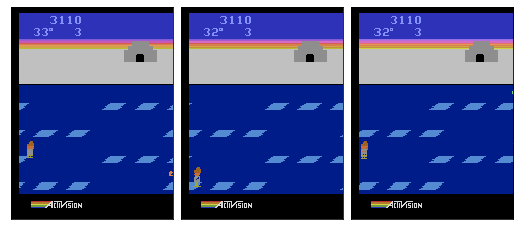

In [134]:
get = itemgetter(5, -8, -2)
plot_observations_by_indices(sample_full_color_observations, get(filtered_mean_m_p_lower_indices[1].indices), title=False, wspace=0.05)

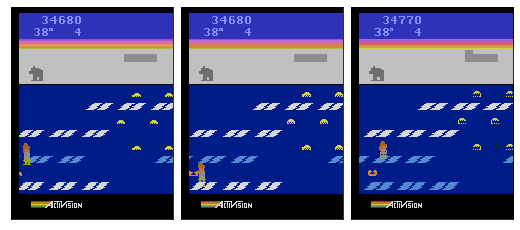

In [140]:
get = itemgetter(2, 4, 7)
plot_observations_by_indices(sample_full_color_observations, get(filtered_mean_m_p_lower_indices[4].indices), title=False, wspace=0.05)

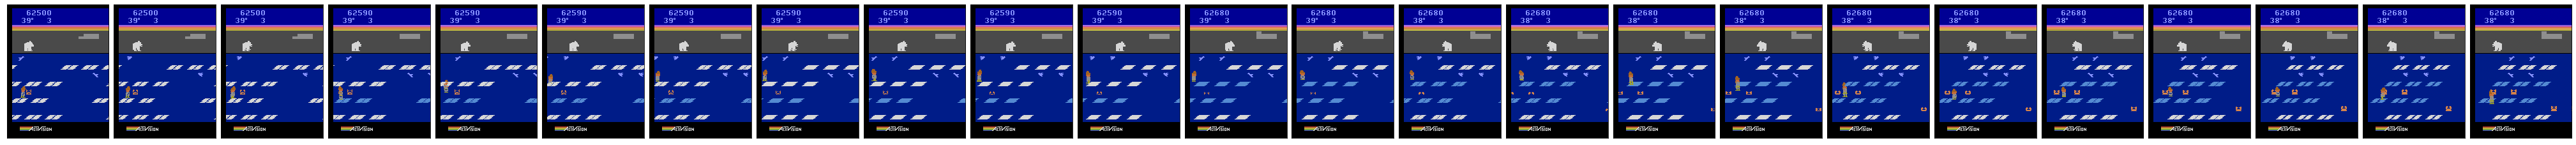

In [137]:
get = itemgetter(5, -8, -2)
plot_observations_by_indices(sample_full_color_observations, filtered_mean_m_p_lower_indices[5].indices, title=False, wspace=0.05)

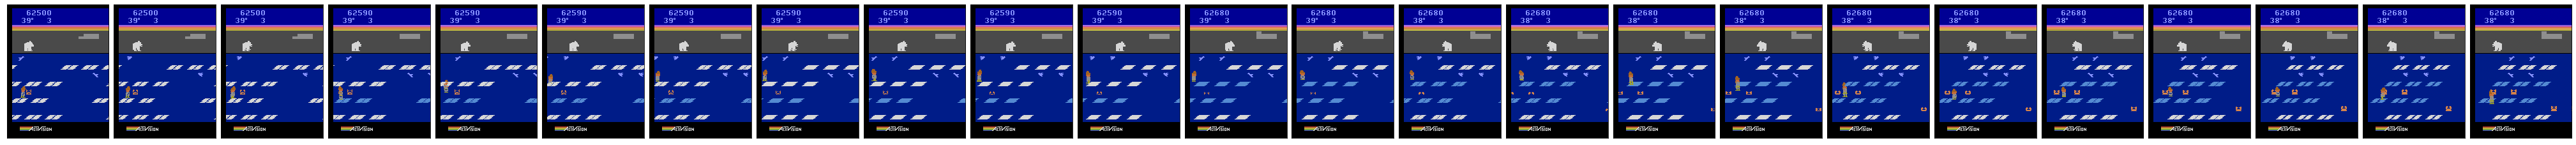

In [141]:
plot_observations_by_indices(sample_full_color_observations, filtered_mean_m_p_lower_indices[5].indices, title=False, wspace=0.05)

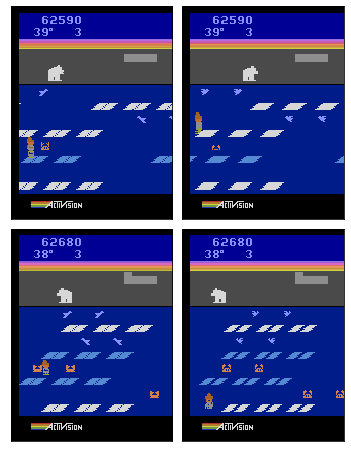

In [146]:
get = itemgetter(3, 10, -4)
ind = list(get(filtered_mean_m_p_lower_indices[5].indices)) + [filtered_mean_m_p_lower_indices[5].indices[-1] + 6]
plot_observations_by_indices(sample_full_color_observations, ind, title=False, wspace=0.05, shape=(2, 2))

16 6
(0) At index 632, the count is 10


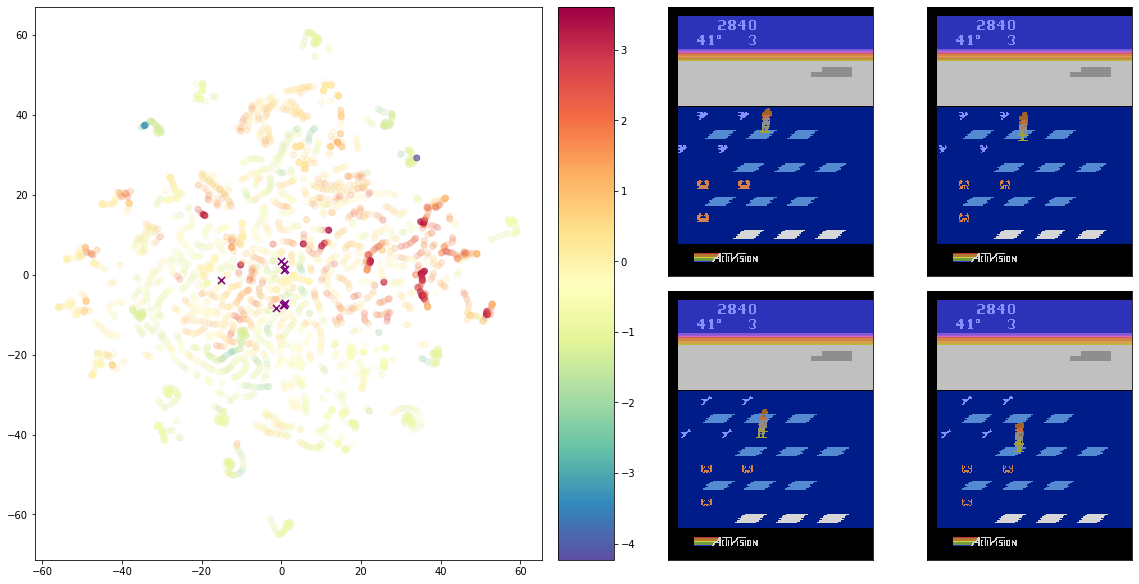

(1) At index 754, the count is 21


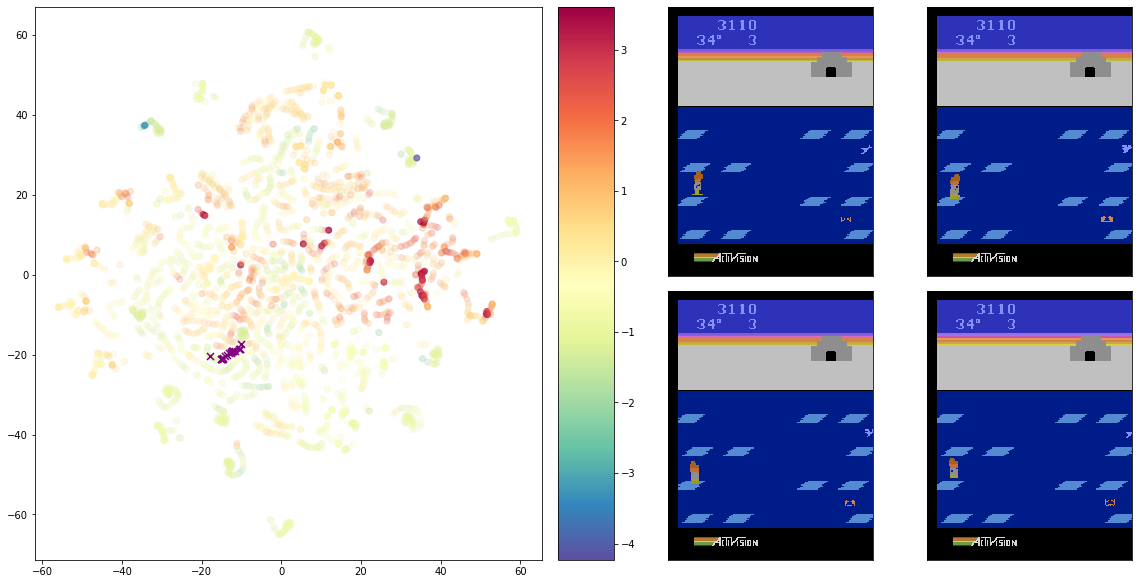

(2) At index 1061, the count is 11


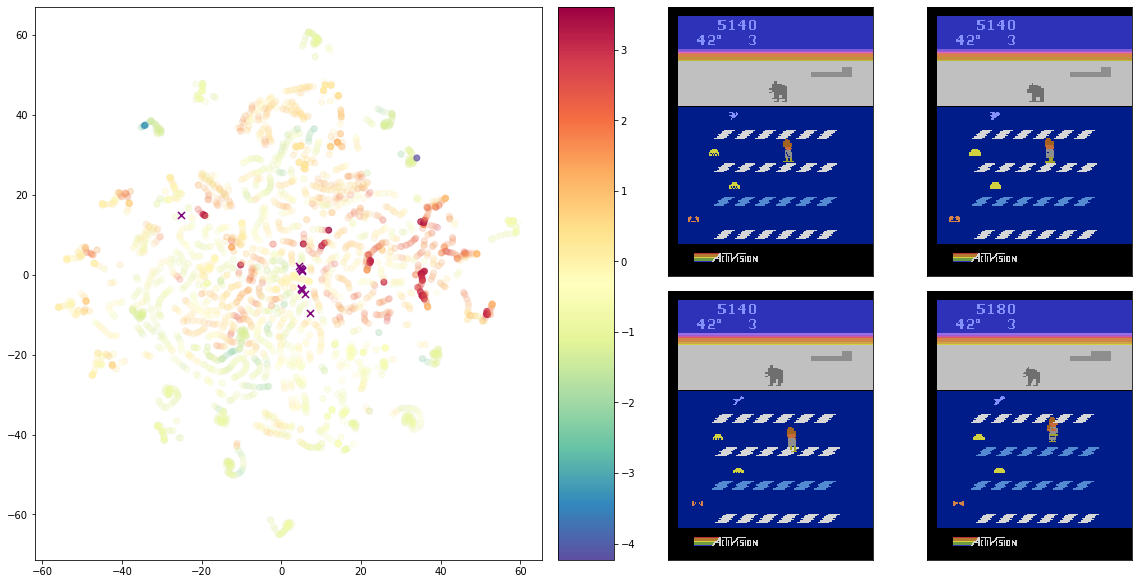

(3) At index 3019, the count is 10


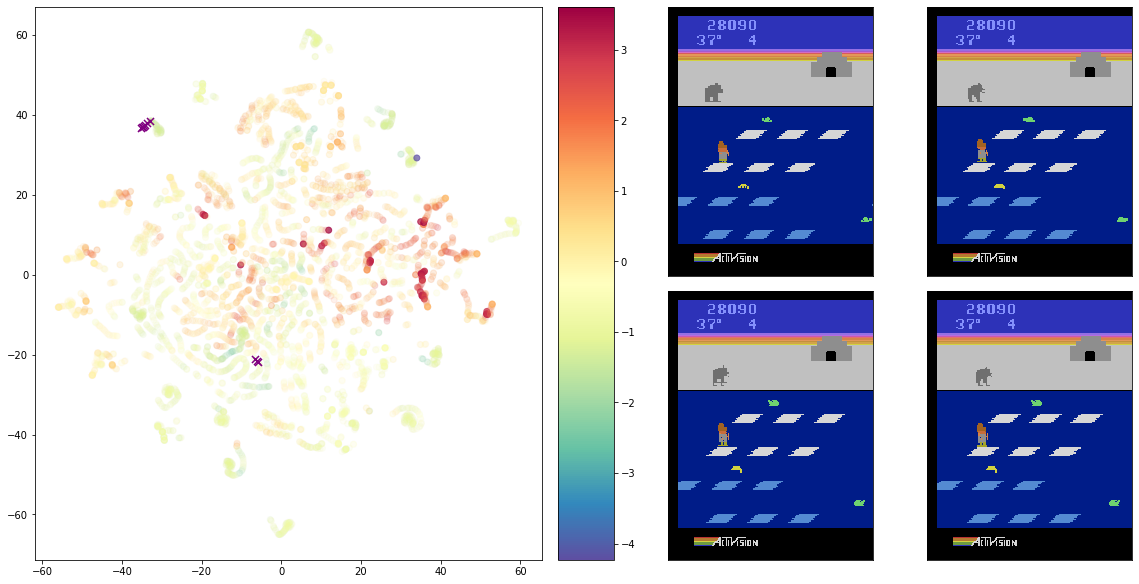

(4) At index 3374, the count is 12


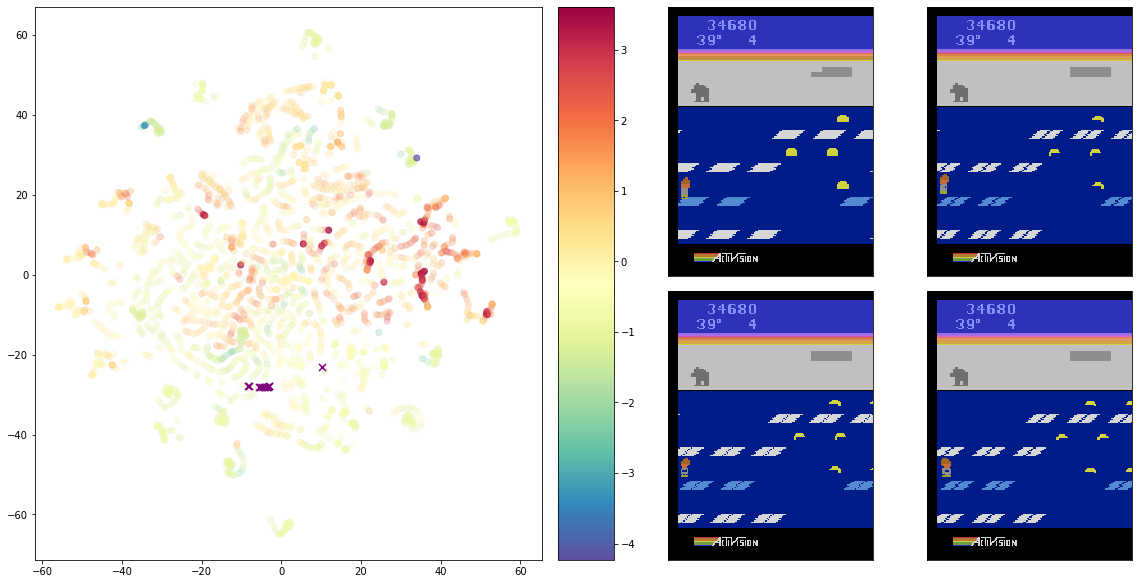

(5) At index 5288, the count is 24


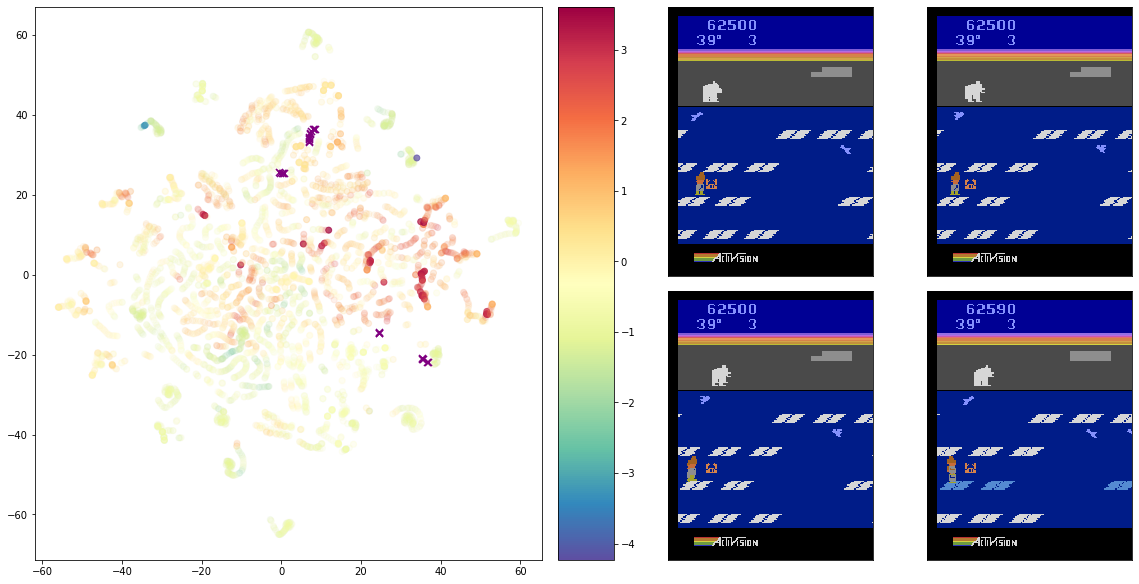

In [129]:
MIN_COUNT = 10
MIN_DISTANCE = 20
MIN_VALUE_DIFF = 1.5

mean_m_p_lower_indices = find_diverging_states(normalized_mean_diffs, np.nonzero(normalized_mean_diffs < -MIN_VALUE_DIFF)[0], min_distance=MIN_DISTANCE)

filtered_mean_m_p_lower_indices = list(filter(lambda ki: ki.count >= MIN_COUNT, mean_m_p_lower_indices))
print(len(mean_m_p_lower_indices), len(filtered_mean_m_p_lower_indices))

for i, key_index in enumerate(sorted(filtered_mean_m_p_lower_indices, key=lambda ki: ki.peak_index)):
        index = key_index.peak_index
        print(f'({i}) At index {index}, the count is {key_index.count}')

        plot_embeddings_and_state(Y, normalized_mean_diffs, sample_full_color_observations, 
                                  key_index.start, 
                                  special_indices=key_index.indices)

In [149]:

from matplotlib.font_manager import findfont, FontProperties
font = findfont(FontProperties(family=matplotlib.rcParams['font.family']))
font

'/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'

## 4

In [28]:
masks_and_pixels_run = api.run('augmented-frostbite/masks-and-pixels-replication/runs/grh1bzvv')
masks_and_pixels_model, masks_and_pixels_env = load_model_from_run(masks_and_pixels_run, 10000000)

Loading pretrained model: /scratch/gd1279/masks-and-pixels-replication-306-10000000.pth


In [29]:
masks_and_pixels_model_results = pass_states_through_model(masks_and_pixels_model, masks_and_pixels_env, sample_full_color_observations, skip=1)

(array([1502.,  446.,  311.,  256.,  261.,  347.,  572.,  769.,  379.,
         825.]),
 array([1.84557e-03, 1.00166e+00, 2.00147e+00, 3.00129e+00, 4.00110e+00,
        5.00092e+00, 6.00073e+00, 7.00055e+00, 8.00036e+00, 9.00018e+00,
        9.99999e+00]),
 <a list of 10 Patch objects>)

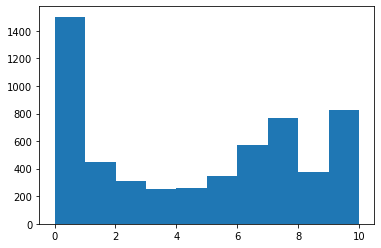

In [30]:
plt.hist(masks_and_pixels_model_results.state_values)

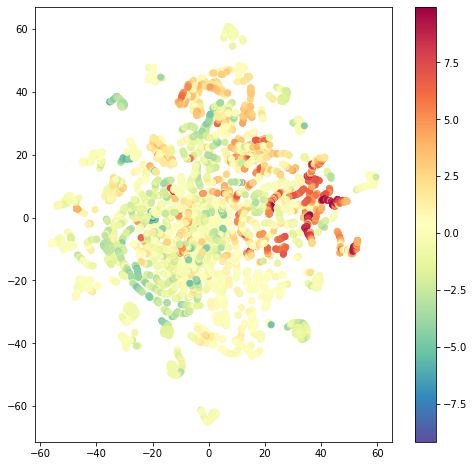

In [31]:
plt.figure(figsize=(8, 8))
cmap = matplotlib.cm.get_cmap('Spectral_r')
plt.scatter(Y[:, 0], Y[:, 1], c=masks_and_pixels_model_results.state_values - baseline_model_results.state_values, cmap=cmap)
plt.colorbar()

-3.814734395405357 3.7163272219517105


(array([2.000e+00, 1.300e+01, 1.650e+02, 7.590e+02, 2.514e+03, 1.193e+03,
        5.110e+02, 2.490e+02, 1.590e+02, 1.030e+02]),
 array([-3.81473, -3.06163, -2.30852, -1.55542, -0.80231, -0.0492 ,
         0.7039 ,  1.45701,  2.21011,  2.96322,  3.71633]),
 <a list of 10 Patch objects>)

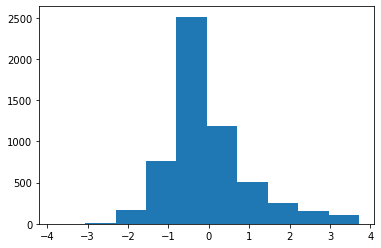

In [32]:
state_value_diffs = masks_and_pixels_model_results.state_values - baseline_model_results.state_values
normalized_diffs = (state_value_diffs - np.mean(state_value_diffs)) / np.std(state_value_diffs)

print(np.min(normalized_diffs), np.max(normalized_diffs))
plt.hist(normalized_diffs)

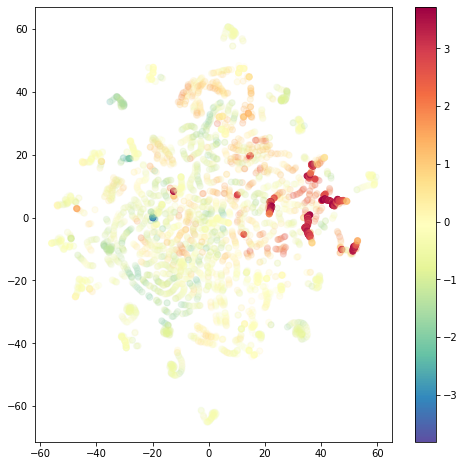

In [33]:
plt.figure(figsize=(8, 8))
cmap = matplotlib.cm.get_cmap('Spectral_r')
normalizer = matplotlib.colors.Normalize(np.min(normalized_diffs), np.max(normalized_diffs))

colors = np.array([cmap(normalizer(d)) for d in normalized_diffs])
colors[:,3] = np.abs(normalized_diffs) / np.max(np.abs(normalized_diffs))
colors[colors[:,3] > 0.7, 3] = 1
colors[colors[:,3] < 0.7, 3] = 0.1

pc = plt.scatter(Y[:, 0], Y[:, 1], color=colors)
plt.colorbar(matplotlib.cm.ScalarMappable(norm=normalizer, cmap=cmap), ax=plt.gca())

In [44]:
sum(normalized_diffs > 3.5), sum(normalized_diffs < -3.5)
print(np.nonzero(normalized_diffs > 3.5))
print(np.nonzero(normalized_diffs < -3.5))

(array([ 198,  199, 1650, 1651, 1662, 1663, 1665, 1666, 1668, 1669, 1671,
       1672, 1674, 1675, 1677, 1678, 1975, 1976, 1977, 1978, 1979, 1981,
       1983, 1984, 1992, 1993, 1995, 1996, 1997, 1998, 1999, 2289, 2295,
       2296, 2302, 2304, 2658, 2659, 2660]),)
(array([481]),)


14
At index 198
masks+pixels had value 9.827 => up + right + fire (14)
(1) up + right + fire [14], Q = 9.827, P = 0.580 | (2) down + right + fire [16], Q = 9.489, P = 0.414 | (3) down [5], Q = 3.501, P = 0.001
baseline had value 0.158 => up + right (6)
(1) up + right [6], Q = 0.158, P = 0.063 | (2) up + left + fire [15], Q = 0.040, P = 0.056 | (3) fire [1], Q = 0.039, P = 0.056


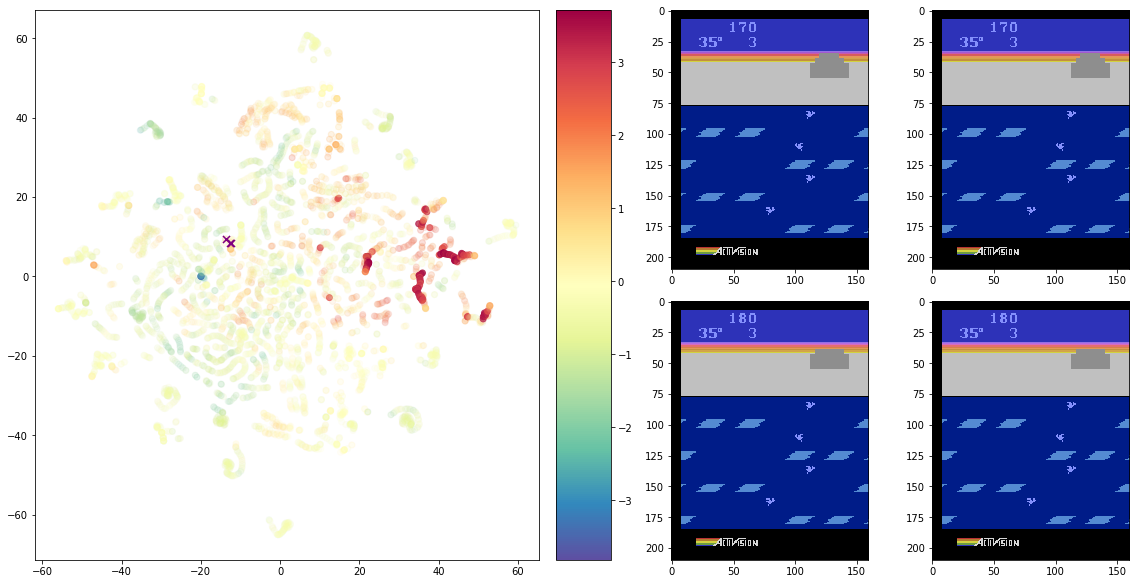

At index 1615
masks+pixels had value 7.315 => up + right (6)
(1) up + right [6], Q = 7.315, P = 0.112 | (2) up + right + fire [14], Q = 7.280, P = 0.108 | (3) up + left + fire [15], Q = 7.088, P = 0.089
baseline had value 0.143 => down + right (8)
(1) down + right [8], Q = 0.143, P = 0.057 | (2) right + fire [11], Q = 0.126, P = 0.056 | (3) down + fire [13], Q = 0.125, P = 0.056


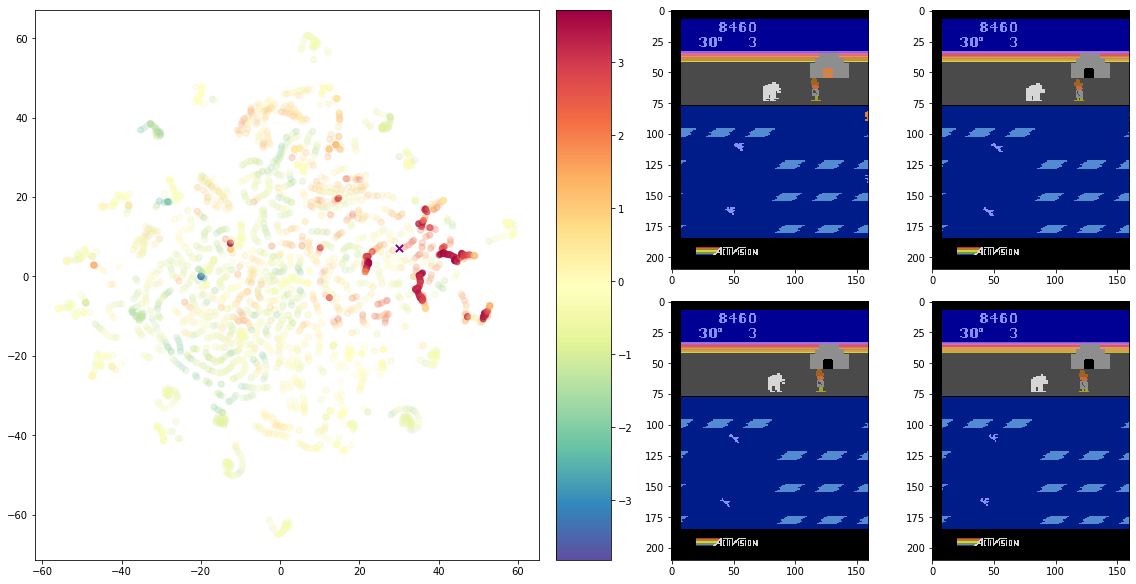

At index 1665
masks+pixels had value 9.967 => down + right + fire (16)
(1) down + right + fire [16], Q = 9.967, P = 0.501 | (2) up + right + fire [14], Q = 9.934, P = 0.485 | (3) up + left + fire [15], Q = 4.525, P = 0.002
baseline had value 0.025 => up + right (6)
(1) up + right [6], Q = 0.025, P = 0.056 | (2) up + right + fire [14], Q = 0.014, P = 0.056 | (3) up + left + fire [15], Q = 0.012, P = 0.056


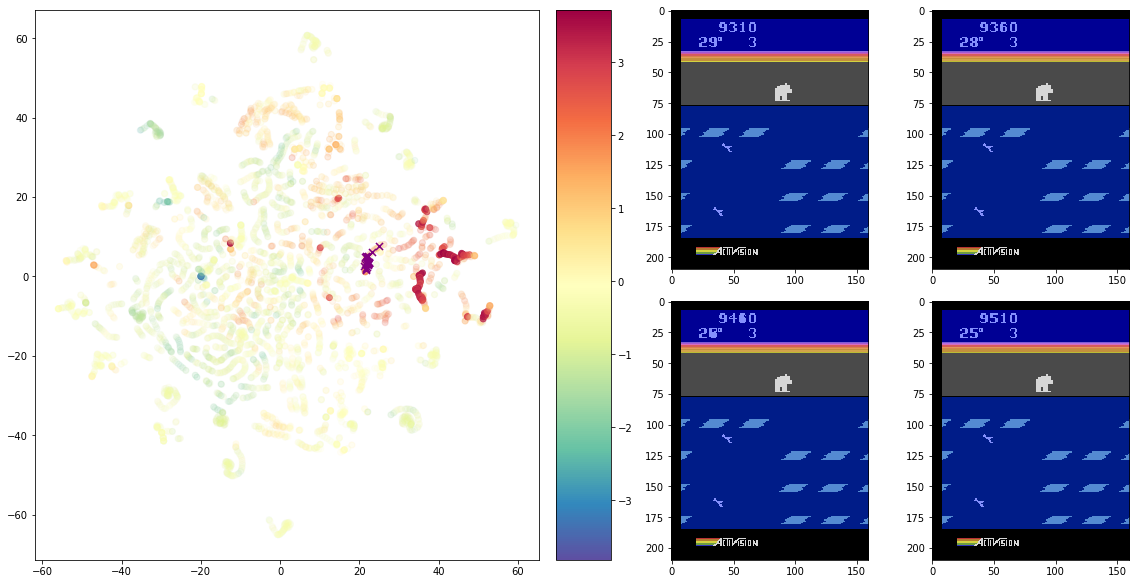

At index 1898
masks+pixels had value 8.663 => down + right + fire (16)
(1) down + right + fire [16], Q = 8.663, P = 0.128 | (2) down + right [8], Q = 8.296, P = 0.089 | (3) down + fire [13], Q = 8.199, P = 0.080
baseline had value 1.295 => up + left (7)
(1) up + left [7], Q = 1.295, P = 0.091 | (2) down + left [9], Q = 1.247, P = 0.087 | (3) up + left + fire [15], Q = 1.221, P = 0.084


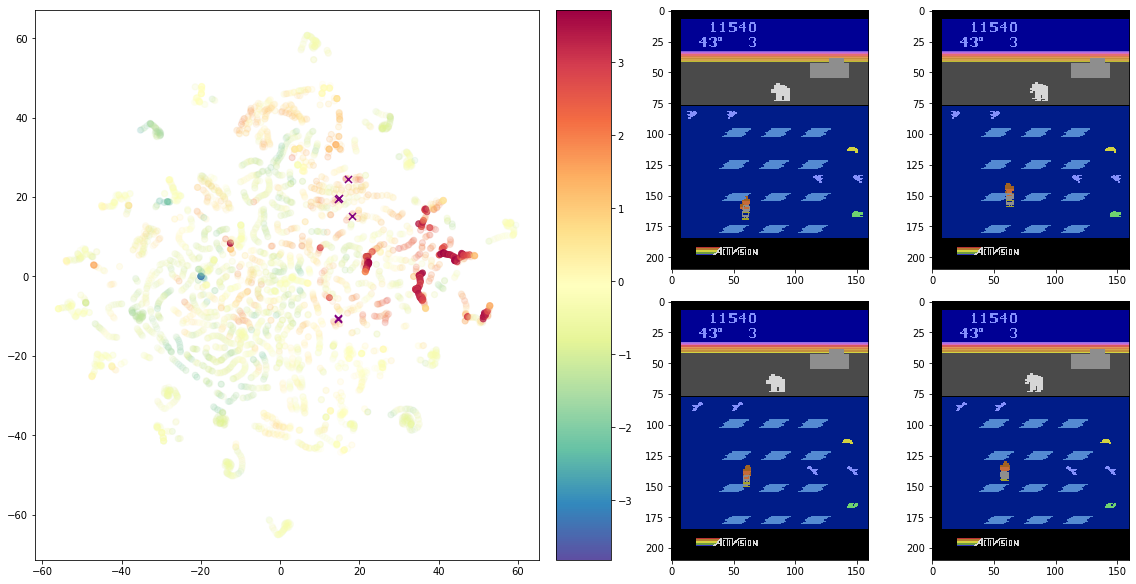

At index 1975
masks+pixels had value 9.977 => up + right + fire (14)
(1) up + right + fire [14], Q = 9.977, P = 0.469 | (2) down + right + fire [16], Q = 9.818, P = 0.400 | (3) down [5], Q = 6.825, P = 0.020
baseline had value 0.065 => left (4)
(1) left [4], Q = 0.065, P = 0.056 | (2) down + fire [13], Q = 0.054, P = 0.056 | (3) up + right [6], Q = 0.053, P = 0.056


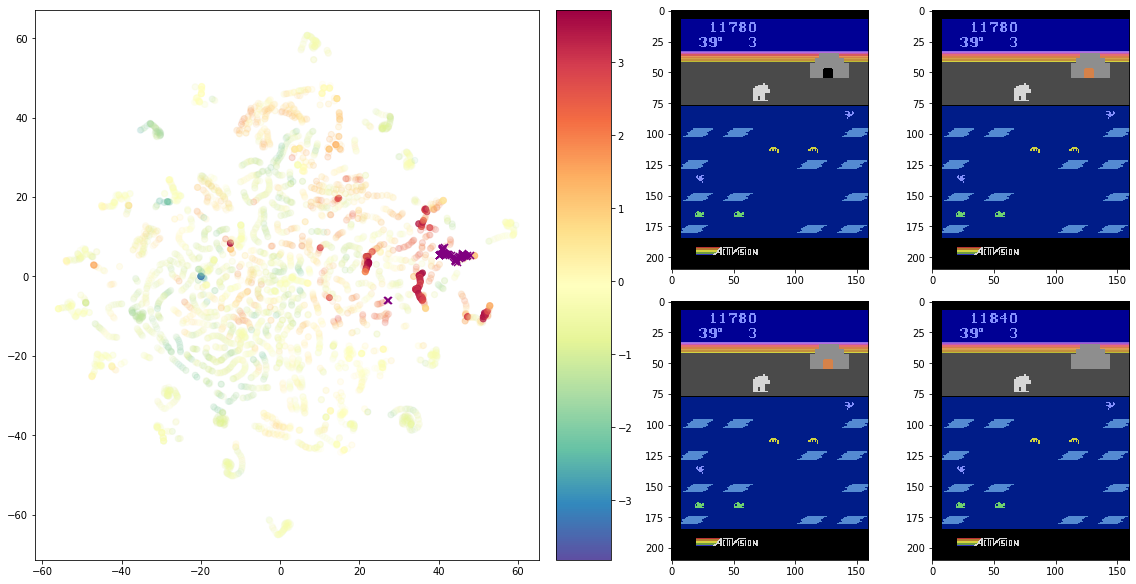

At index 2261
masks+pixels had value 8.176 => up + right + fire (14)
(1) up + right + fire [14], Q = 8.176, P = 0.793 | (2) down + right + fire [16], Q = 6.533, P = 0.153 | (3) down + left [9], Q = 3.503, P = 0.007
baseline had value 0.094 => down + right (8)
(1) down + right [8], Q = 0.094, P = 0.057 | (2) left [4], Q = 0.072, P = 0.056 | (3) fire [1], Q = 0.071, P = 0.056


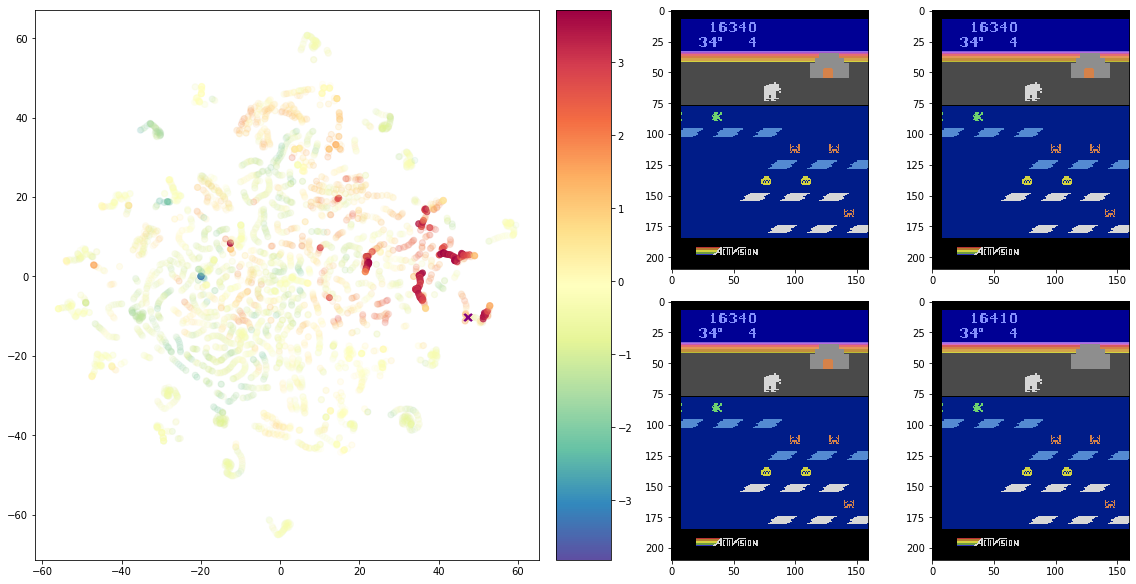

At index 2296
masks+pixels had value 9.936 => down + right + fire (16)
(1) down + right + fire [16], Q = 9.936, P = 0.433 | (2) up + right + fire [14], Q = 9.861, P = 0.402 | (3) up + left + fire [15], Q = 7.169, P = 0.027
baseline had value 0.416 => down (5)
(1) down [5], Q = 0.416, P = 0.059 | (2) fire [1], Q = 0.412, P = 0.059 | (3) up + right [6], Q = 0.398, P = 0.058


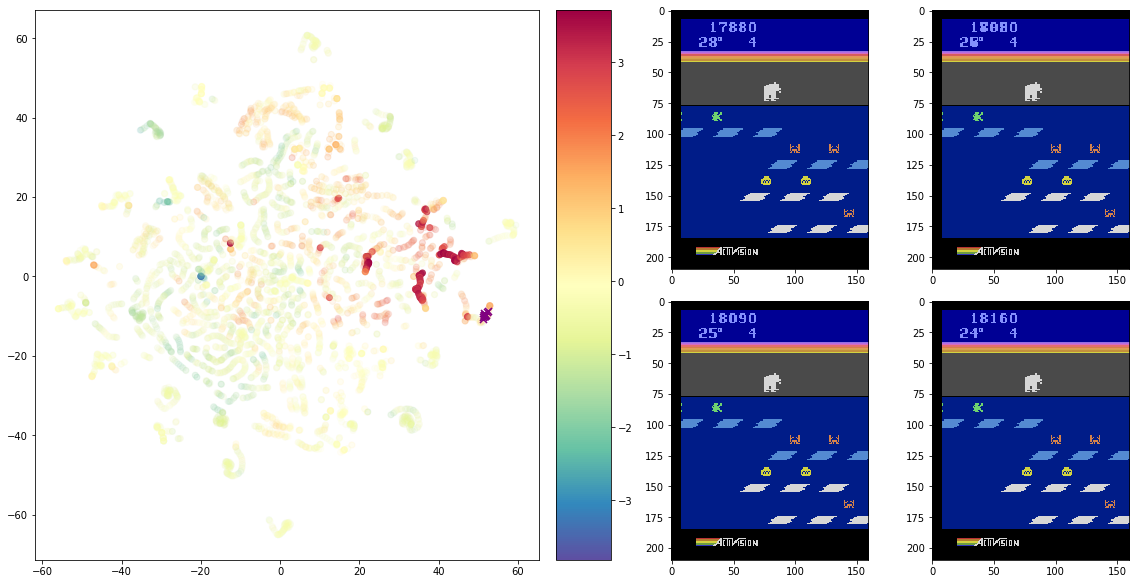

At index 2388
masks+pixels had value 7.843 => down + left (9)
(1) down + left [9], Q = 7.843, P = 0.094 | (2) down + right + fire [16], Q = 7.609, P = 0.075 | (3) up + left + fire [15], Q = 7.527, P = 0.069
baseline had value 0.639 => up + right + fire (14)
(1) up + right + fire [14], Q = 0.639, P = 0.073 | (2) up + right [6], Q = 0.616, P = 0.071 | (3) down [5], Q = 0.507, P = 0.064


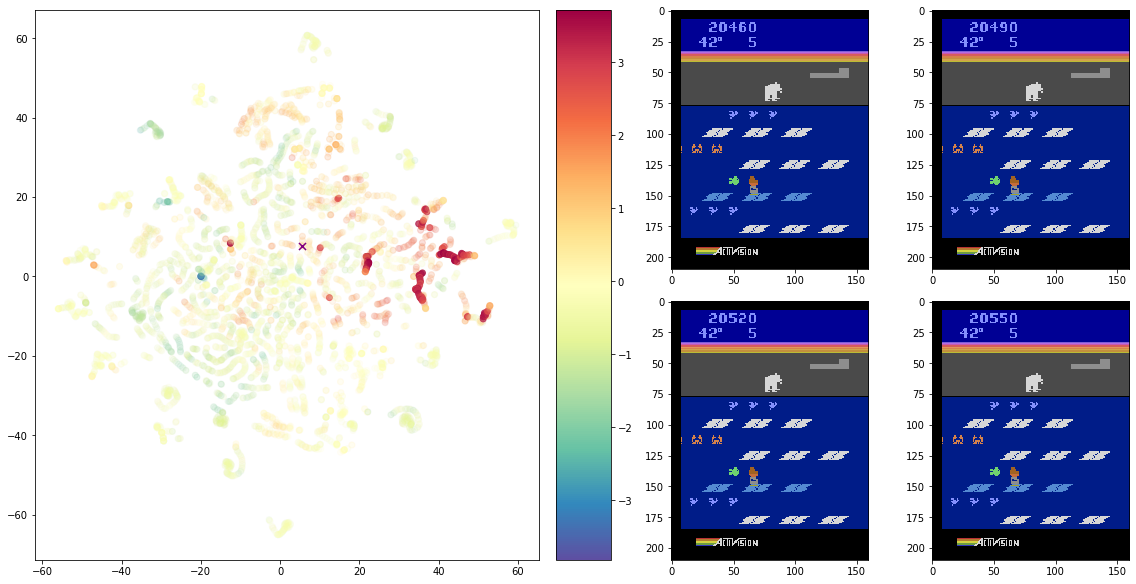

At index 2401
masks+pixels had value 8.613 => up + fire (10)
(1) up + fire [10], Q = 8.613, P = 0.083 | (2) up + right + fire [14], Q = 8.444, P = 0.070 | (3) down [5], Q = 8.442, P = 0.070
baseline had value 0.776 => up + left (7)
(1) up + left [7], Q = 0.776, P = 0.075 | (2) down [5], Q = 0.745, P = 0.073 | (3) up + right + fire [14], Q = 0.738, P = 0.072


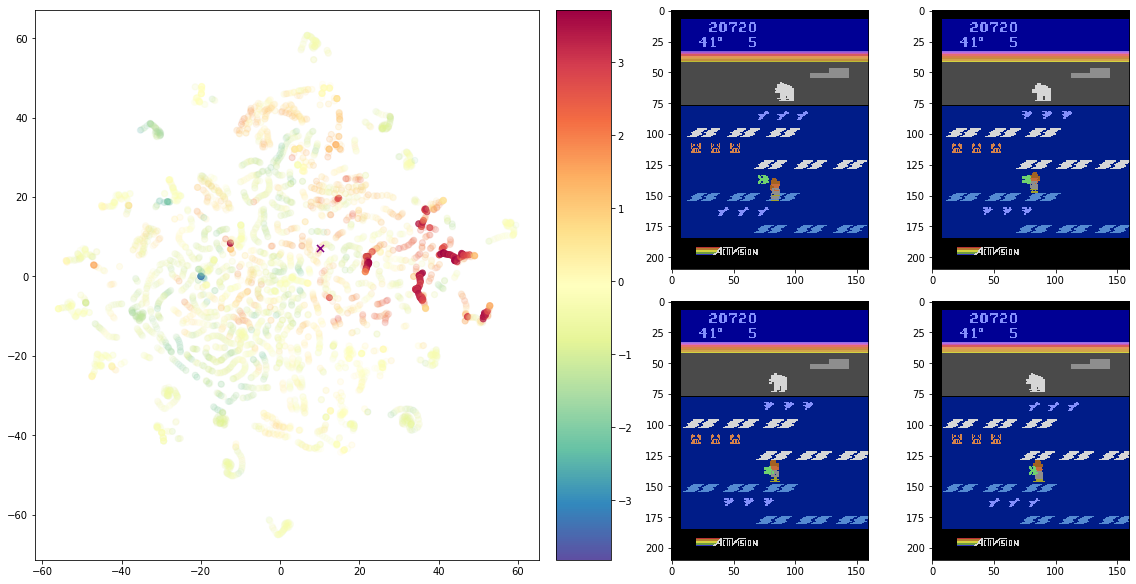

At index 2658
masks+pixels had value 9.858 => up + right + fire (14)
(1) up + right + fire [14], Q = 9.858, P = 0.730 | (2) down + right + fire [16], Q = 8.850, P = 0.266 | (3) down [5], Q = 2.575, P = 0.001
baseline had value 0.160 => down + left (9)
(1) down + left [9], Q = 0.160, P = 0.057 | (2) left [4], Q = 0.150, P = 0.056 | (3) left + fire [12], Q = 0.149, P = 0.056


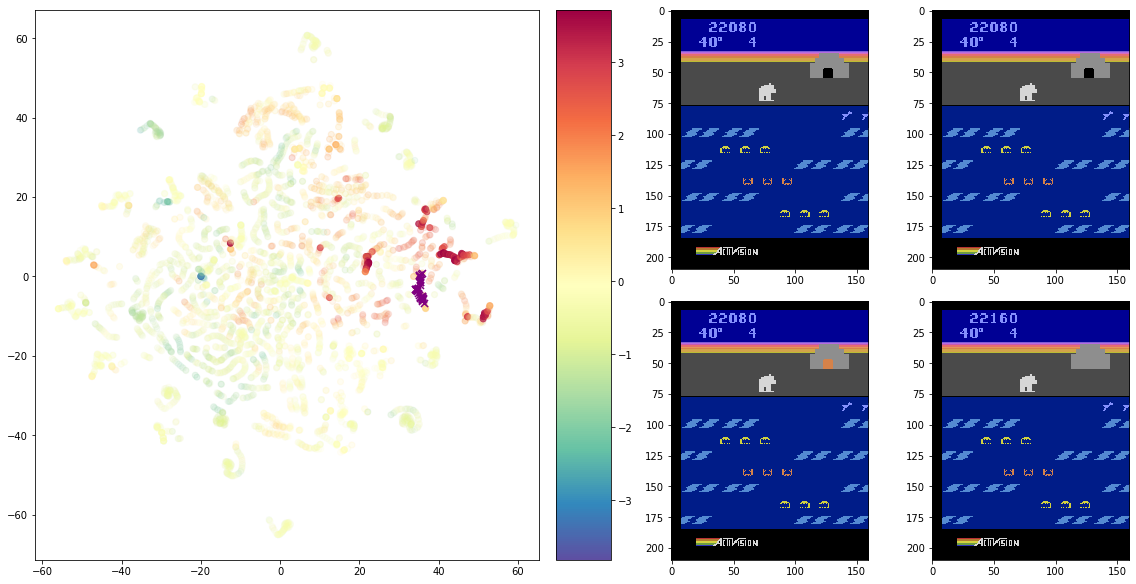

At index 3852
masks+pixels had value 7.633 => up + fire (10)
(1) up + fire [10], Q = 7.633, P = 0.060 | (2) left + fire [12], Q = 7.608, P = 0.058 | (3) up + left + fire [15], Q = 7.605, P = 0.058
baseline had value 0.613 => up + left (7)
(1) up + left [7], Q = 0.613, P = 0.086 | (2) up + right + fire [14], Q = 0.432, P = 0.071 | (3) up + left + fire [15], Q = 0.243, P = 0.059


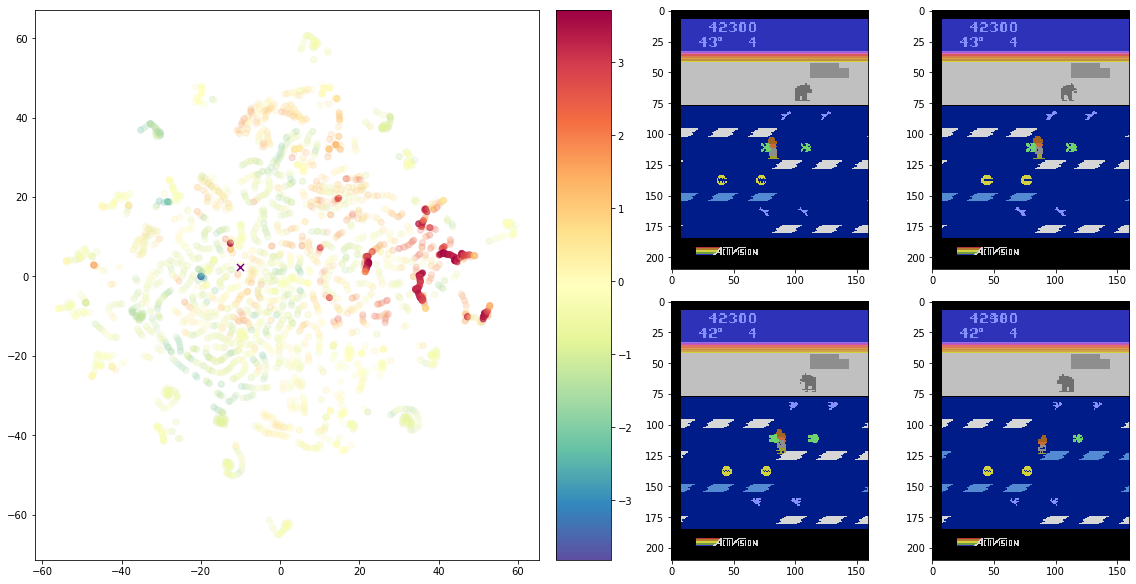

At index 5108
masks+pixels had value 9.946 => up + right + fire (14)
(1) up + right + fire [14], Q = 9.946, P = 0.652 | (2) down + right + fire [16], Q = 9.213, P = 0.313 | (3) up + fire [10], Q = 6.124, P = 0.014
baseline had value 0.579 => right (3)
(1) right [3], Q = 0.579, P = 0.058 | (2) right + fire [11], Q = 0.570, P = 0.058 | (3) down + fire [13], Q = 0.569, P = 0.058


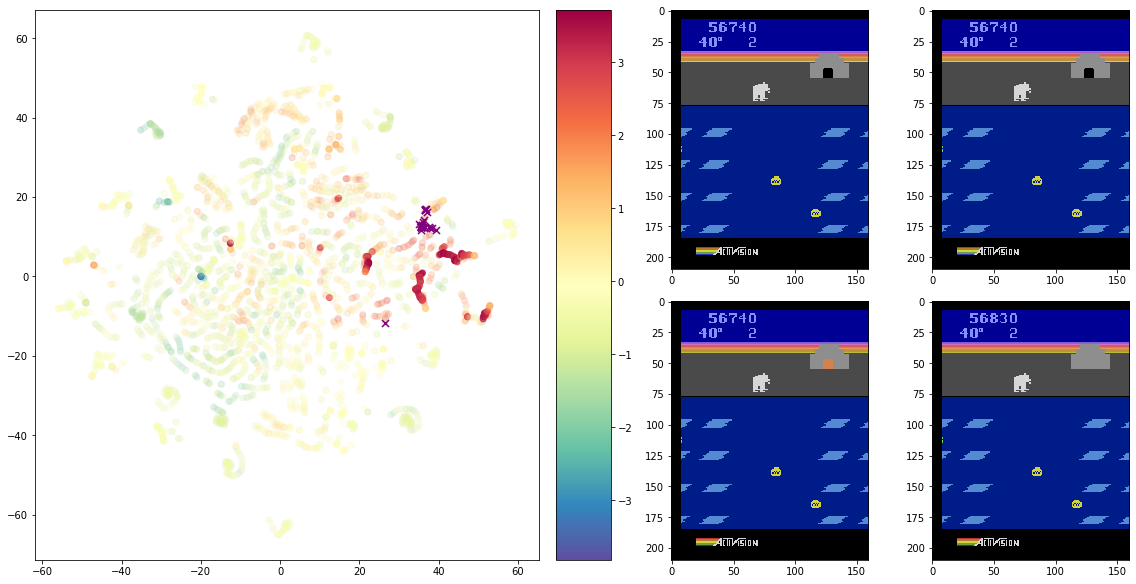

At index 5152
masks+pixels had value 9.934 => down + right + fire (16)
(1) down + right + fire [16], Q = 9.934, P = 0.306 | (2) up + right + fire [14], Q = 9.896, P = 0.295 | (3) up + left + fire [15], Q = 7.900, P = 0.040
baseline had value 2.745 => right (3)
(1) right [3], Q = 2.745, P = 0.064 | (2) up + right [6], Q = 2.720, P = 0.062 | (3) down + right [8], Q = 2.720, P = 0.062


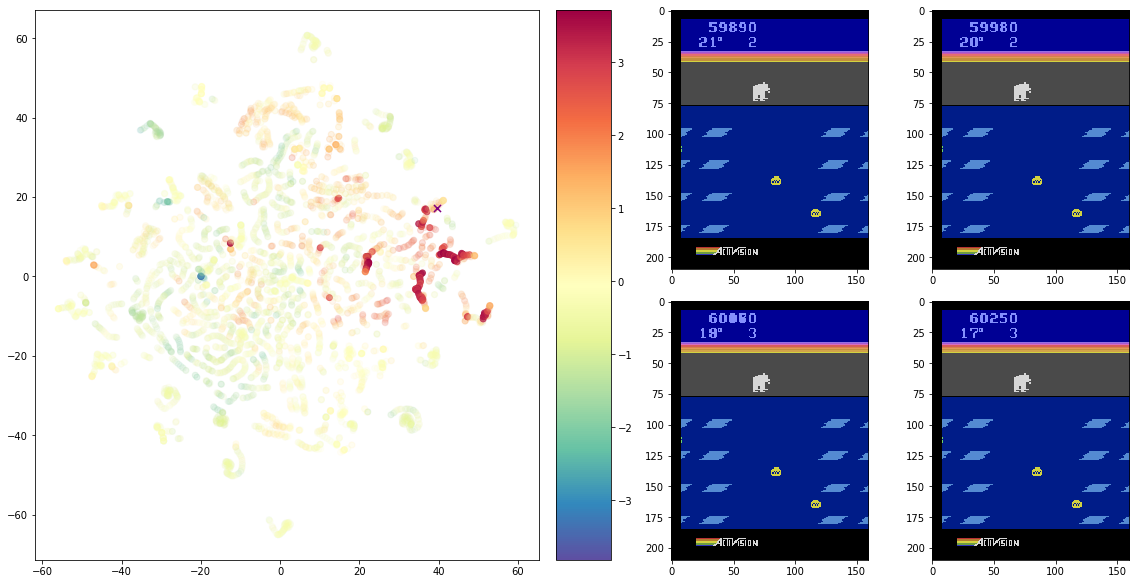

At index 5224
masks+pixels had value 8.774 => down (5)
(1) down [5], Q = 8.774, P = 0.114 | (2) down + right + fire [16], Q = 8.423, P = 0.081 | (3) down + left [9], Q = 8.338, P = 0.074
baseline had value 1.462 => up (2)
(1) up [2], Q = 1.462, P = 0.061 | (2) up + right [6], Q = 1.453, P = 0.060 | (3) up + fire [10], Q = 1.447, P = 0.060


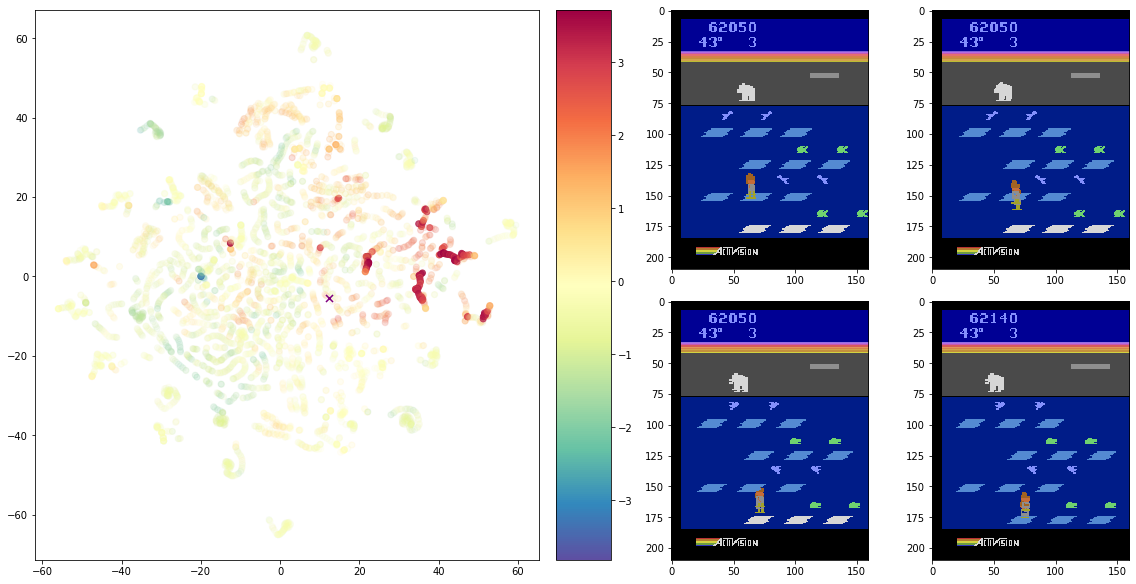

In [45]:
masks_and_pixel_higher_indices = find_diverging_states(normalized_diffs, np.nonzero(normalized_diffs > 2.5)[0])
print(len(masks_and_pixel_higher_indices))
describe_states_by_indices(masks_and_pixel_higher_indices,
                           masks_and_pixels_model_results, 'masks+pixels', baseline_model_results, 'baseline',
                           sample_full_color_observations, Y, normalized_diffs, plot_embeddings=True)

In [ ]:
for cluster in masks_and_pixel_higher_indices:
    embeddings = Y[cluster.indices]
    mean = np.tile(np.mean(embeddings, 0), (embeddings.shape[0], 1))
    print(embeddings.shape[0], mean_squared_error(embeddings, mean))

-----------

In [ ]:
masks_and_pixel_lower_indices = find_diverging_states(normalized_diffs, np.nonzero(normalized_diffs < -2.5)[0])
print(len(masks_and_pixel_lower_indices))
describe_states_by_indices(masks_and_pixel_lower_indices,
                           masks_and_pixels_model_results, 'masks+pixels', baseline_model_results, 'baseline',
                           sample_full_color_observations, Y, normalized_diffs, plot_embeddings=True)

# Repeating some of this analysis with a masks only model

In [ ]:
masks_only_run = api.run('augmented-frostbite/masks-only-replication/runs/0khc2n2c')
masks_only_model, masks_only_env = load_model_from_run(masks_only_run, 10000000)
masks_only_model_results = pass_states_through_model(masks_only_model, masks_only_env, sample_full_color_observations, skip=1)

In [ ]:
plt.hist(masks_only_model_results.state_values)

In [ ]:
masks_only_state_value_diffs = masks_only_model_results.state_values - baseline_model_results.state_values
masks_only_normalized_diffs = (masks_only_state_value_diffs - np.mean(masks_only_state_value_diffs)) / np.std(masks_only_state_value_diffs)

print(np.min(masks_only_normalized_diffs), np.max(masks_only_normalized_diffs))
plt.hist(masks_only_normalized_diffs)

In [ ]:
plt.figure(figsize=(8, 8))
cmap = matplotlib.cm.get_cmap('Spectral_r')
normalizer = matplotlib.colors.Normalize(np.min(masks_only_normalized_diffs), np.max(masks_only_normalized_diffs))

colors = np.array([cmap(normalizer(d)) for d in masks_only_normalized_diffs])
colors[:,3] = np.abs(masks_only_normalized_diffs) / np.max(np.abs(masks_only_normalized_diffs))
colors[colors[:,3] > 0.7, 3] = 1
colors[colors[:,3] < 0.7, 3] = 0.1

pc = plt.scatter(Y[:, 0], Y[:, 1], color=colors)
plt.colorbar(matplotlib.cm.ScalarMappable(norm=normalizer, cmap=cmap), ax=plt.gca())

In [ ]:
masks_only_indices = find_diverging_states(masks_only_normalized_diffs, np.nonzero(masks_only_normalized_diffs > 2.5)[0])
print(len(masks_only_indices))
describe_states_by_indices(masks_only_indices,
                           masks_only_model_results, 'masks only', baseline_model_results, 'baseline',
                           sample_full_color_observations, Y, masks_only_normalized_diffs, plot_embeddings=True)

In [ ]:
masks_only_indices = find_diverging_states(masks_only_normalized_diffs, np.nonzero(masks_only_normalized_diffs < -2.5)[0])
print(len(masks_only_indices))
describe_states_by_indices(masks_only_indices,
                           masks_only_model_results, 'masks only', baseline_model_results, 'baseline',
                           sample_full_color_observations, Y, masks_only_normalized_diffs, plot_embeddings=True)

# One final thought -- what if we compare values between augmented models

In [ ]:
augmented_state_value_diffs = masks_and_pixels_model_results.state_values - masks_only_model_results.state_values
augmented_normalized_diffs = (augmented_state_value_diffs - np.mean(augmented_state_value_diffs)) / np.std(augmented_state_value_diffs)

print(np.min(augmented_normalized_diffs), np.max(augmented_normalized_diffs))
plt.hist(augmented_normalized_diffs)

In [ ]:
plt.figure(figsize=(8, 8))
cmap = matplotlib.cm.get_cmap('Spectral_r')
normalizer = matplotlib.colors.Normalize(np.min(augmented_normalized_diffs), np.max(augmented_normalized_diffs))

colors = np.array([cmap(normalizer(d)) for d in augmented_normalized_diffs])
colors[:,3] = np.abs(augmented_normalized_diffs) / np.max(np.abs(augmented_normalized_diffs))
colors[colors[:,3] > 0.7, 3] = 1
colors[colors[:,3] < 0.7, 3] = 0.1

pc = plt.scatter(Y[:, 0], Y[:, 1], color=colors)
plt.colorbar(matplotlib.cm.ScalarMappable(norm=normalizer, cmap=cmap), ax=plt.gca())

In [ ]:
augmented_indices = find_diverging_states(augmented_normalized_diffs, np.nonzero(augmented_normalized_diffs > 2.5)[0])
print(len(augmented_indices))
describe_states_by_indices(augmented_indices,
                           masks_and_pixels_model_results, 'masks and pixels', masks_only_model_results, 'masks only',
                           sample_full_color_observations, Y, augmented_normalized_diffs, plot_embeddings=True)

In [ ]:
augmented_indices = find_diverging_states(augmented_normalized_diffs, np.nonzero(augmented_normalized_diffs < -2.5)[0])
print(len(augmented_indices))
describe_states_by_indices(augmented_indices,
                           masks_and_pixels_model_results, 'masks and pixels', masks_only_model_results, 'masks only',
                           sample_full_color_observations, Y, augmented_normalized_diffs, plot_embeddings=True)